---
# Ähnlichkeit von Job-Stellenausschreibungen mit Word2Vec-Ansatz
by Tobia Ippolito

---

## Table of Content

- [Aufgabenstellung](#Aufgabenstellung)
- [Wann ist eine Stellenausschreibung ähnlich?](#Wann-ist-eine-Stellenausschreibung-ähnlich?)
- [Grundgedanke](#Grundgedanke)
- [Imports](#Imports)
- [Preparations](#Preparation)
- Experimente
    - [Word2Vec Similarity der Jobbeschreibung](#Experiment-1:-Word2Vec-Similarity-der-Jobbeschreibung)
    - [Word2Vec der Jobbeschreibung mit nur wichtigen Wörtern](#Experiment-2:-Word2Vec-der-Jobbeschreibung-mit-nur-wichtigen-Wörtern)
    - [Word2Vec der Jobbeschreibung mit nur Entitäten](#Experiment-3:-Word2Vec-der-Jobbeschreibung-mit-nur-Entitäten)
    - [Word2Vec der Jobbeschreibung mit nur wichtigen Wörtern und anderer Ausrechnungsart 1](#Experiment-4:-Word2Vec-der-Jobbeschreibung-mit-nur-wichtigen-Wörtern-und-anderer-Ausrechnungsart-1)
    - [Word2Vec der Jobbeschreibung mit nur wichtigen Wörtern und anderer Ausrechnungsart 2](#Experiment-5:-Word2Vec-der-Jobbeschreibung-mit-nur-wichtigen-Wörtern-und-anderer-Ausrechnungsart-2)
    - [Ähnlichkeit der Job-Titel mit Word2vec](#Experiment-6:-Ähnlichkeit-der-Job-Titel-mit-Word2vec)
    - [Ähnlichkeit der Job-Kategorien](#Experiment-7:-Ähnlichkeit-der-Job-Kategorien)
    - [Ähnlichkeit der Job-Orte](#Experiment-8:-Ähnlichkeit-der-Job-Orte)
    - [Ähnlichkeit der Job-Art](#Experiment-9:-Ähnlichkeit-der-Job-Art)
    - [Point-Gain-Proceedings](#Experiment-10:-Point-Gain-Proceedings)
    - [Parallelisierung](#Experiment-11:-Paralleles-Ausführen)
- [Evaluation](#Evaluation)
- [Anwendung](#Anwendung)
- [Profiling](#Profiling)
- [Location Runtime Test](#Location-Runtime-Test)
- [Trimmed Category Calc](#Trimmed-Category-Calc)

<br>

> ***Hinweis**: Klicken Sie sich einfach zu den jeweiligen Kapiteln. Dort befinden sich rechts Racketen, welche sie mit einem Klick wieder hier hin bringen, wo Sie von neuem weiter navigieren können.* <img src="./rackete_1.png" style="float:right" width=50></img>

<br>

---

### Aufgabenstellung

Finden von ähnlichen Job-Posts
Stellen Sie sich vor, ein/e Bewerber/in hat eine für ihn / sie interessante Stelle gefunden. Nun
würde er/sie gerne automatisch ähnliche Stellen vorgeschlagen bekommen, die auch
interessant sein könnten. Wie könnte eine entsprechende Funktionalität implementiert
werden?

> Definieren Sie zunächst, wann eine Stelle in diesem Szenario als ähnlich gesehen
werden sollte.

> Überlegen Sie dann, mit welchen Ansätzen diese Art von Ähnlichkeit erfasst werden kann.

> Setzen Sie diese anschließend um. Verwenden Sie Experimente und gehen Sie strukturiert vor.

<br>

---

### Wann ist eine Stellenausschreibung ähnlich?

Eigenschaften eine Job-Posts:
- Job Beschreibung
- Job Titel
- Kategorie/Thema
- Ort (Stadt, Land, Unternehmen)
- Plattform
- Berufsart


Arten der Ähnlichkeit bei Job-Posts:
- Ansprüche 
- Fachgebiet
- Spezieller Beruf/Bezeichnung (Ähnlichkeit der Aktivität)
- Gehalt
- Firma
- Plattform
- Ort
- Berufsart (Teilszeit, ...)
- Textlänge
- Grammatik


Tatsächlich ist keine objektive Ähnlichkeit festzulegen. Stattdessen ist es subjektiv, wie ähnlich sich Berufstellenanzeigen sind. So ist für eine Person ein naher/ähnlicher Ort wichtig und für eine andere, dass es Vollzeit ist.<br>
Generell gehe ich jedoch davon aus, dass die wichtigste Eigenschaft der Beruf an sich ist (Berufsbezeichnung).

---
### Grundgedanke

Zum einen soll die Suche flexibel und individuell anpassbar sein, da wir [gerade](#Wann-ist-eine-Stellenausschreibung-ähnlich?) gesehen haben, dass die Ähnlichkeit bei Job-Posts subjektiv ist.<br>
Zum anderen soll das Verfahren Word2Vec zur verwendung kommen. Dieses Verfahren stellt Wörter nämlich so dar, dass ähnliche Wörter mit repräsentiert werden. Dies wollen wir uns in dieser Arbeit zunutze machen.<br>
Ein Job-Post besteht zu einem großen Teil aus Wörtern, welche einen semantischen Sinn haben und welcher auch von großer Bedeutung ist -> Jobbezeichnung + Jobbeschreibung.

---

### Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sn

import spacy
from spacy.tokens import Token

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

import multiprocessing as mp

import time
import cProfile
import warnings

---

### Preparation
<!--<p style="float:right">Up</p>-->

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

**Loading Data**

In [6]:
!pip install openpyxl

In [7]:
data = pd.read_excel("../data_scientist_united_states_job_postings_jobspikr.xlsx")

In [8]:
data.head()

,crawl_timestamp,url,job_title,category,company_name,city,state,country,inferred_city,inferred_state,...,job_description,job_type,salary_offered,job_board,geo,cursor,contact_email,contact_phone_number,uniq_id,html_job_description
0,2019-02-06 06:26:22,https://www.indeed.com/viewjob?jk=fd83355c2b23...,Enterprise Data Scientist I,Accounting/Finance,Farmers Insurance Group,Woodland Hills,CA,Usa,Woodland hills,California,...,Read what people are saying about working here...,Undefined,NaN,indeed,usa,1549432819114777,NaN,NaN,3b6c6acfcba6135a31c83bd7ea493b18,NaN
1,2019-02-06 06:33:41,https://www.dice.com/jobs/detail/Data-Scientis...,Data Scientist,NaN,Luxoft USA Inc,Middletown,NJ,Usa,Middletown,New jersey,...,We have an immediate opening for a Sharp Data ...,Undefined,NaN,dice,usa,1549432819122106,NaN,NaN,741727428839ae7ada852eebef29b0fe,NaN
2,2019-02-06 06:33:35,https://www.dice.com/jobs/detail/Data-Scientis...,Data Scientist,NaN,Cincinnati Bell Technology Solutions,New York,NY,Usa,New york,New york,...,Candidates should have the following backgroun...,Full Time,NaN,dice,usa,1549432819236156,NaN,NaN,cdc9ef9a1de327ccdc19cc0d07dbbb37,NaN
3,2019-02-06 06:33:42,https://www.indeed.com/viewjob?jk=841edd86ead2...,"Data Scientist, Aladdin Wealth Tech, Associate...",Accounting/Finance,BlackRock,New York,NY 10055 (Midtown area),Usa,New york,New york,...,Read what people are saying about working here...,Undefined,NaN,indeed,usa,1549432819259473,NaN,NaN,1c8541cd2c2c924f9391c7d3f526f64e,NaN
4,2019-02-06 06:48:23,https://job-openings.monster.com/senior-data-s...,Senior Data Scientist,biotech,CyberCoders,Charlotte,NC,Usa,Charlotte,North carolina,...,We are seeking an extraordinary Data Scientist...,Full Time,NaN,monster,usa,1549436429015957,NaN,NaN,445652a560a5441060857853cf267470,NaN


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   crawl_timestamp       10000 non-null  datetime64[ns]
 1   url                   10000 non-null  object        
 2   job_title             10000 non-null  object        
 3   category              9118 non-null   object        
 4   company_name          9999 non-null   object        
 5   city                  9751 non-null   object        
 6   state                 9584 non-null   object        
 7   country               10000 non-null  object        
 8   inferred_city         8980 non-null   object        
 9   inferred_state        9484 non-null   object        
 10  inferred_country      9505 non-null   object        
 11  post_date             10000 non-null  datetime64[ns]
 12  job_description       10000 non-null  object        
 13  job_type         

In [10]:
data.shape

(10000, 22)

---

Download bigger SpaCy train text with:<br>
python -m spacy download en_core_web_lg

Or in Anaconda:<br>
conda install spacy-model-en_core_web_lg

Create an Example:

- job1 = Farmer job    - Accounting/Finance
- job2 = Finance job (investing, black rock)   - Accounting/Finance
- job3 = Data Science (analytics)
- job4 = Data Science (small text, machine learning)
- job5 = Data Science 

In [11]:
job_con = {'job1':0, 'job2':3, 'job3':4, 'job4':2, 'job5':1}

In [12]:
job1 = data['job_description'][0]    # farmer
job2 = data['job_description'][3]    # finance -> inevsting, black rock
job3 = data['job_description'][4]    # data science -> analytics / bio
job4 = data['job_description'][2]    # data science -> machine learning
job5 = data['job_description'][1]    # data science -> mathematics

jobs_ = (job1, job2, job3, job4, job5)

Evaluation Function for evaulate a result

In [13]:
def eval_similarity(similarity_matrix, labels, heatmap=True, k=1):
    """
    Evaluation function for similarity.
    """
    if not heatmap:
        fig, ax = plt.subplots(nrows=(len(labels)+1)//2, ncols=2, figsize=(15, 15))  #, constrained_layout=True
        #fig.tight_layout()
        plt.subplots_adjust(hspace = 0.3)

        row_ = 0
        col_ = 0

        for i, sim in enumerate(similarity_matrix):
            # create cmap with normalize values
            my_cmap = plt.cm.get_cmap('GnBu')
            colors = my_cmap([x / max(sim) for x in sim])
            # plot one job simiralities
            ax[row_][col_].set_title(f"Similarities from job{i+1}")
            ax[row_][col_].bar(labels, sim, edgecolor='black', color=colors)
            ax[row_][col_].grid()

            # add colorbar
            sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(sim)))
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax[row_][col_])
            cbar.set_label('Color', rotation=270,labelpad=25)

            # update col and row for axes indices
            if col_ == 1:
                col_ = 0
                row_ += 1
            else:
                col_ += 1

        plt.plot()
    else:
        # create mask for only half
        mask = np.triu(similarity_matrix, k=k)
        # np.ones_like(similarity_matrix, dtype=bool)
        #print(mask)
        
        df_color_map = pd.DataFrame(similarity_matrix, index=labels, columns=labels)
        plt.figure(figsize = (10,7))
        plt.title("Job Similarities")
        sn.heatmap(df_color_map, annot=True, cmap=sn.cm.rocket_r, mask=mask)

In [14]:
def create_similarity_matrix(sim_func, jobs):
    similarity_matrix = []
    for i in jobs:
        cache = []
        for j in jobs:
            cache += [sim_func(i, j)]
        similarity_matrix += [cache]
    return similarity_matrix

**Hinweis an den Leser:**

Bei der Evaluierung der folgenden Experimente wäre folgendes Ergebnis ein optimales Ergebnis. Nur um dies besser einordnen zu können.

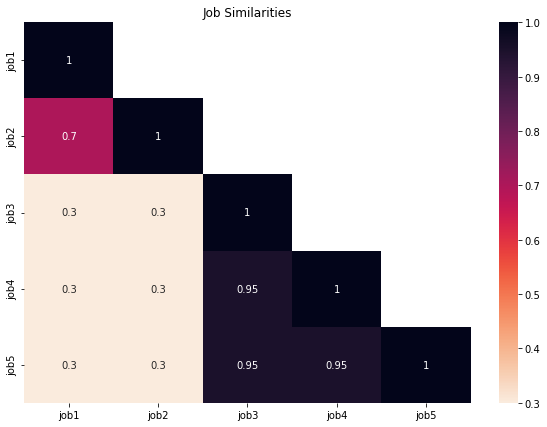

In [15]:
template = [[1, 0.7, 0.3, 0.3, 0.3], 
           [0.7, 1, 0.3, 0.3, 0.3],
           [0.3, 0.3, 1, 0.95, 0.95],
           [0.3, 0.3, 0.95, 1, 0.95],
           [0.3, 0.3, 0.95, 0.95, 1]]
eval_similarity(template, ["job1", "job2", "job3", "job4", "job5"])

Die Jobs 3-5 sind ähnliche Jobs und sonst sind alle verschieden.

---


### **Experiment 1:** Word2Vec Similarity der Jobbeschreibung

In diesem Experiment soll die Ähnlichkeit der Stellenausschreibungen mithilfe des Word2Vec-Distanz der Job-Beschreibungen evaluiert werden.<br>
Die Jobbeschreibung wird in diesem Experiment nicht verändert.

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In [16]:
nlp = spacy.load("en_core_web_lg")

doc1 = nlp(job1)
doc2 = nlp(job2)
doc3 = nlp(job3)
doc4 = nlp(job4)
doc5 = nlp(job5)

In [17]:
jobs = (doc1, doc2, doc3, doc4, doc5)
job_labels = ["job1", "job2", "job3", "job4", "job5"]

In [18]:
doc1.similarity(doc2)

0.9840876837987785

In [19]:
doc1.similarity(doc3)

0.9855178678414908

In [20]:
doc2.similarity(doc3)

0.9882321369734971

In [21]:
doc1[:].similarity(doc5)

0.9802072187890001

In [22]:
doc3[:].similarity(doc4[:])

0.9440867304801941

In [23]:
doc3[:].similarity(doc5[:])

0.9785909652709961

In [24]:
doc4[:].similarity(doc5[:])

0.9545732736587524

In [25]:
similarity = create_similarity_matrix(lambda x,y: x.similarity(y), jobs)

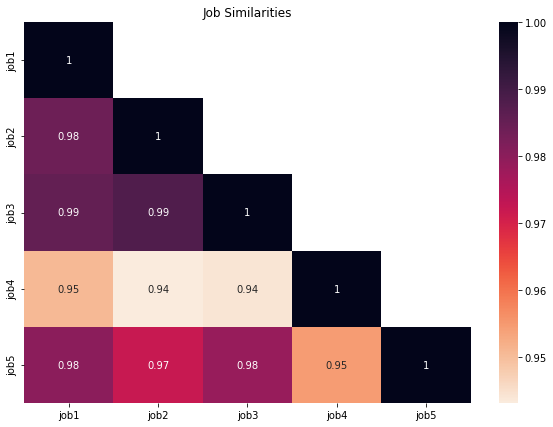

In [26]:
eval_similarity(similarity, job_labels, heatmap=True)

**Ergebnis:**

Zunächst fällt auf, dass alle Jobbeschreibungen als sehr ähnlich eingestuft werden, was diesen Ansatz schonmal für nicht so optimal einstuft.<br> 
Nur die 4.te Jobbeschreibung scheint nicht so ähnlich wie die 4 anderen Jobbeschreibungen zu sein. Die Jobbeschreibung dessen ist auch eindeutig kürzer und es könnte sich damit um einen Ausreißer handeln.<br>
<br>
So oder so ist dieser Ansatz nicht zu gebrauchen, da die Jobbeschreibungen sich damit nicht trennen lassen.

---
### **Experiment 2:** Word2Vec der Jobbeschreibung mit nur wichtigen Wörtern

In diesem Experiment soll die Ähnlichkeit der Stellenausschreibungen mithilfe des Word2Vec-Distanz der Job-Beschreibungen evaluiert werden.<br>
Die Jobbeschreibung wird in diesem Experiment auf die wichtigsten Wörter reduziert (Nomen, Adjektiven). Die Auswirkung auf die Ähnlichkeit wird hierbei getestet.

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In [27]:
# remove stopwords and unimportant words in Spacy Pipeline
def get_important_words(doc, which=['NOUN', 'PROPN', 'ADJ']):
    """
    Prepares the job description and removes all words except nouns and verbs
    """
    cache = []
    for token in doc:
        if token.pos_ in which:    #'VERB',
            cache += [token.text]
    return cache

In [28]:
#[print(i.text, i.pos_) for i in nlp(job3)]

In [29]:
# remove nouns and than build a new doc out of these smaller descriptions
nlp = spacy.load("en_core_web_lg")

# remove not important words
prepared_jobs = []
for job in jobs_:
    prepared_jobs += [get_important_words(nlp(job))]
    
# build docs with the reduced text

doc1 = nlp(' '.join(prepared_jobs[0]))
doc2 = nlp(' '.join(prepared_jobs[1]))
doc3 = nlp(' '.join(prepared_jobs[2]))
doc4 = nlp(' '.join(prepared_jobs[3]))
doc5 = nlp(' '.join(prepared_jobs[4]))

jobs = (doc1, doc2, doc3, doc4, doc5)
job_labels = ["job1", "job2", "job3", "job4", "job5"]

In [30]:
sim_matrix = create_similarity_matrix(lambda x,y: x.similarity(y), jobs)

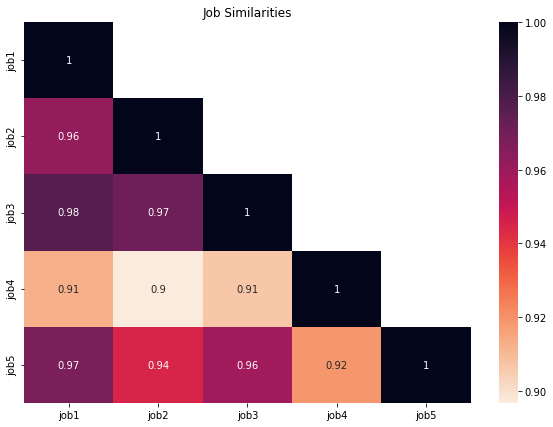

In [31]:
eval_similarity(sim_matrix, job_labels)

Weitere Kombinationen der wichtigsten Wörter probieren

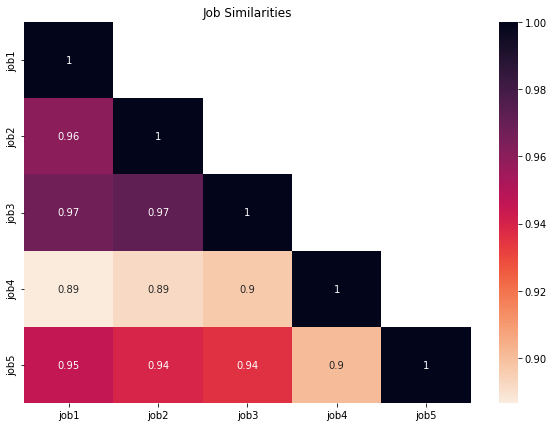

In [32]:
prepared_jobs = []
for job in jobs_:
    prepared_jobs += [get_important_words(nlp(job), which=['NOUN'])]
    
# build docs with the reduced text

doc1 = nlp(' '.join(prepared_jobs[0]))
doc2 = nlp(' '.join(prepared_jobs[1]))
doc3 = nlp(' '.join(prepared_jobs[2]))
doc4 = nlp(' '.join(prepared_jobs[3]))
doc5 = nlp(' '.join(prepared_jobs[4]))

jobs = (doc1, doc2, doc3, doc4, doc5)
job_labels = ["job1", "job2", "job3", "job4", "job5"]

sim_matrix = create_similarity_matrix(lambda x,y: x.similarity(y), jobs)
eval_similarity(sim_matrix, job_labels)

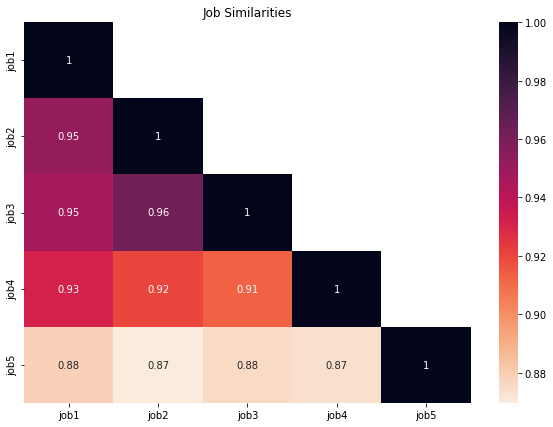

In [33]:
prepared_jobs = []
for job in jobs_:
    prepared_jobs += [get_important_words(nlp(job), which=['VERB'])]
    
# build docs with the reduced text

doc1 = nlp(' '.join(prepared_jobs[0]))
doc2 = nlp(' '.join(prepared_jobs[1]))
doc3 = nlp(' '.join(prepared_jobs[2]))
doc4 = nlp(' '.join(prepared_jobs[3]))
doc5 = nlp(' '.join(prepared_jobs[4]))

jobs = (doc1, doc2, doc3, doc4, doc5)
job_labels = ["job1", "job2", "job3", "job4", "job5"]

sim_matrix = create_similarity_matrix(lambda x,y: x.similarity(y), jobs)
eval_similarity(sim_matrix, job_labels)

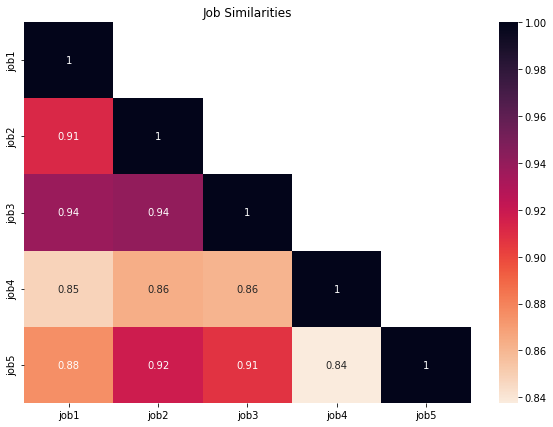

In [34]:
prepared_jobs = []
for job in jobs_:
    prepared_jobs += [get_important_words(nlp(job), which=['ADJ'])]
    
# build docs with the reduced text

doc1 = nlp(' '.join(prepared_jobs[0]))
doc2 = nlp(' '.join(prepared_jobs[1]))
doc3 = nlp(' '.join(prepared_jobs[2]))
doc4 = nlp(' '.join(prepared_jobs[3]))
doc5 = nlp(' '.join(prepared_jobs[4]))

jobs = (doc1, doc2, doc3, doc4, doc5)
job_labels = ["job1", "job2", "job3", "job4", "job5"]

sim_matrix = create_similarity_matrix(lambda x,y: x.similarity(y), jobs)
eval_similarity(sim_matrix, job_labels)

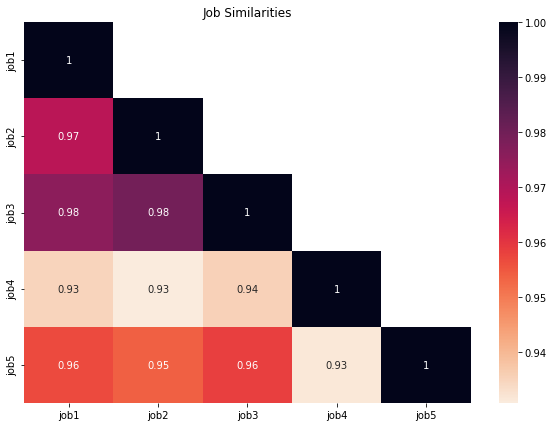

In [35]:
prepared_jobs = []
for job in jobs_:
    prepared_jobs += [get_important_words(nlp(job), which=['NOUN', 'ADJ', 'VERB'])]
    
# build docs with the reduced text

doc1 = nlp(' '.join(prepared_jobs[0]))
doc2 = nlp(' '.join(prepared_jobs[1]))
doc3 = nlp(' '.join(prepared_jobs[2]))
doc4 = nlp(' '.join(prepared_jobs[3]))
doc5 = nlp(' '.join(prepared_jobs[4]))

jobs = (doc1, doc2, doc3, doc4, doc5)
job_labels = ["job1", "job2", "job3", "job4", "job5"]

sim_matrix = create_similarity_matrix(lambda x,y: x.similarity(y), jobs)
eval_similarity(sim_matrix, job_labels)

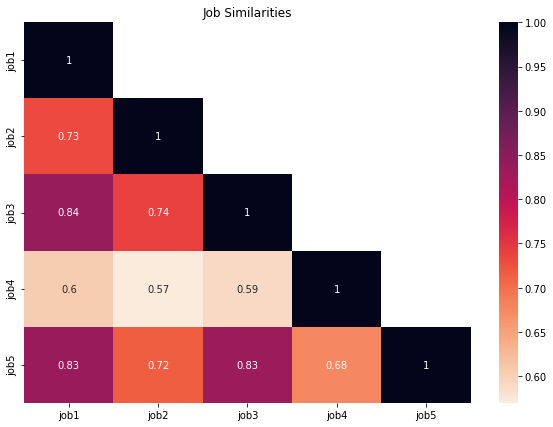

In [36]:
prepared_jobs = []
for job in jobs_:
    prepared_jobs += [get_important_words(nlp(job), which=['PROPN'])]
    
# build docs with the reduced text

doc1 = nlp(' '.join(prepared_jobs[0]))
doc2 = nlp(' '.join(prepared_jobs[1]))
doc3 = nlp(' '.join(prepared_jobs[2]))
doc4 = nlp(' '.join(prepared_jobs[3]))
doc5 = nlp(' '.join(prepared_jobs[4]))

jobs = (doc1, doc2, doc3, doc4, doc5)
job_labels = ["job1", "job2", "job3", "job4", "job5"]

sim_matrix = create_similarity_matrix(lambda x,y: x.similarity(y), jobs)
eval_similarity(sim_matrix, job_labels)

**Ergebnis:**

Die Ähnlichkeiten sind sich ziemlich ähnlich, nur die Jobbeschreibung 4 ist zu allen anderen ca. 5-10% unähnlicher.
Die Ergebnisse sind somit fast identisch zu denen des Experiments 1. Einziger Unterschied ist, dass die Werte etwas unterhalb liegen.
<br>Dabei liegen die Ergebnisse immer im selben Bereich, egal welche der Arten, wie die wichtigsten Wörter berechnet werden, gewählt wird.<br>Nur wenn nur noch die Verben verwendet werden sehen die Ergebnisse für den Job 4 und Job 5 anders aus. Jedoch immer  noch nicht, wie es aussehen soll. <br>
<br>
Auch dieser Ansatz ist unbrauchbar, da die Ähnlichkeiten nicht mit der Realität übereinstimmen.

---

### **Experiment 3:** Word2Vec der Jobbeschreibung mit nur Entitäten

In diesem Experiment soll die Ähnlichkeit der Stellenausschreibungen mithilfe des Word2Vec-Distanz der Job-Beschreibungen evaluiert werden.<br>
Die Jobbeschreibung wird in diesem Experiment auf die Entitäten reduziert. Die Auswirkung auf die Ähnlichkeit wird hierbei getestet.

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In [37]:
# build nlp of ents

nlp = spacy.load("en_core_web_lg")

# get only entities
ents_ = []
for job in jobs_:
    cache = ""
    for ent in nlp(job).ents:
        cache += f"{ent.text} " 
    ents_ += [cache]
    
# wrap in doc for similarity calculation
jobs = [nlp(ent) for ent in ents_]
job_labels = ["job1", "job2", "job3", "job4", "job5"]

In [38]:
similarity = create_similarity_matrix(lambda x,y: x.similarity(y), jobs)

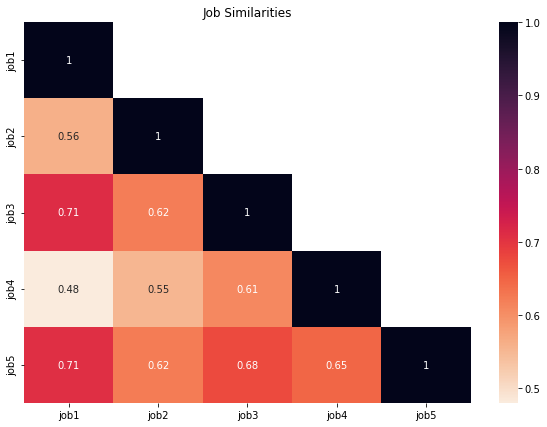

In [39]:
eval_similarity(similarity, job_labels, heatmap=True)

**Ergebnis:**

Der Ansatz erzielt keine guten Resultate. Job 2 ist hiernach ähnlich zu den jobs 3 und 5. Genauso verhält es sich bei dem Job 1 und zwar noch extremer und gerade diese sind ja nicht ähnlich. Die Jobs 3-5 werden hierbei auch nur als etwas ähnlich eingestuft.

---
### **Experiment 4:** Word2Vec der Jobbeschreibung mit nur wichtigen Wörtern und anderer Ausrechnungsart 1

In diesem Experiment soll die Ähnlichkeit der Stellenausschreibungen mithilfe des Word2Vec-Distanz der Job-Beschreibungen evaluiert werden.<br>
Dabei wird die Ähnlichkeit so berechnet, dass die Ähnlichkeit von jedem Wort zu jedem Wort summiert wird.

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In [40]:
# remove nouns and than build a new doc out of these smaller descriptions
nlp = spacy.load("en_core_web_lg")

# remove not important words
prepared_jobs = []
for job in jobs_:
    prepared_jobs += [get_important_words(nlp(job))]
    
# build docs with the reduced text

doc1 = nlp(' '.join(prepared_jobs[0]))
doc2 = nlp(' '.join(prepared_jobs[1]))
doc3 = nlp(' '.join(prepared_jobs[2]))
doc4 = nlp(' '.join(prepared_jobs[3]))
doc5 = nlp(' '.join(prepared_jobs[4]))

jobs = (doc1, doc2, doc3, doc4, doc5)
job_labels = ["job1", "job2", "job3", "job4", "job5"]

In [41]:
# sum of similarities
def job_description_sum_similarity(post1, post2):
    """
    Calculates the similarity between 2 job descriptions.
    Both descriptions should be cleaned (stopword removing)
    and given as list/doc.
    """
    text_similarity = dict()
    # calculate similarity sum
    for token in post1:
        sum_sim = 0
        for token_other in post2:
            sum_sim += token.similarity(token_other)

        # saves similarity sum in dict
        label = token.text
        i = 1
        while label in text_similarity.keys():
            label = f"token.text{i}"
            i += 1
        text_similarity[label] = sum_sim
        
    return sum(text_similarity.values())/((len(post1)+len(post2))*100)

In [42]:
sim_matrix = create_similarity_matrix(job_description_sum_similarity, jobs)

C:\Users\tobia\AppData\Local\Temp\ipykernel_19840\869645819.py:13: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  sum_sim += token.similarity(token_other)


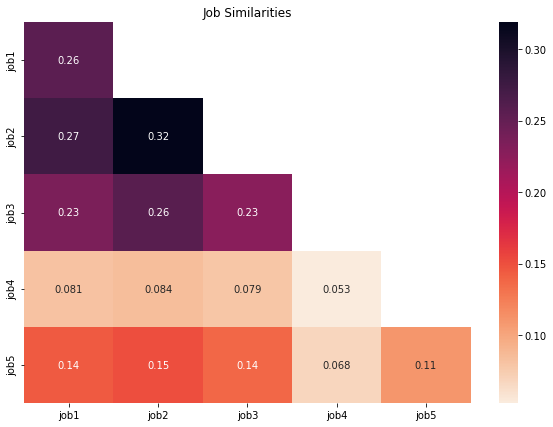

In [43]:
eval_similarity(sim_matrix, job_labels)

**Ergebnis:** 

Dieses Verfahren zeigt bei den gleichen Posts eine Unähnlichkeit an, womit es damit eindeutig unbrauchbar ist und Ähnlichkeit nicht gut berechnen kann. <br>
Auch bei den restlichen Resultate (wie damit dann auch zu erwarten ist) schneidet das verfahren sehr schlecht ab. So Sind die Jobbeschreibungen 1-3 fast gleich ähnlich zu der Jobbeschreibung 5, was in der Realität nicht der Fall ist.

---
### **Experiment 5:** Word2Vec der Jobbeschreibung mit nur wichtigen Wörtern und anderer Ausrechnungsart 2

In diesem Experiment soll die Ähnlichkeit der Stellenausschreibungen mithilfe des Word2Vec-Distanz der Job-Beschreibungen evaluiert werden.<br>
Dabei wird die Ähnlichkeit so berechnet, dass ähnliche Wörter gezählt werden.

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In [44]:
# remove nouns and than build a new doc out of these smaller descriptions
nlp = spacy.load("en_core_web_lg")

# remove not important words
prepared_jobs = []
for job in jobs_:
    prepared_jobs += [get_important_words(nlp(job))]
    
# build docs with the reduced text

doc1 = nlp(' '.join(prepared_jobs[0]))
doc2 = nlp(' '.join(prepared_jobs[1]))
doc3 = nlp(' '.join(prepared_jobs[2]))
doc4 = nlp(' '.join(prepared_jobs[3]))
doc5 = nlp(' '.join(prepared_jobs[4]))

jobs = (doc1, doc2, doc3, doc4, doc5)
job_labels = ["job1", "job2", "job3", "job4", "job5"]

In [45]:
# Or Count similar words
# go throw tokens and calc similarity
    # full similarity -> sum with all other tokens
def job_description_similarity_counter(post1, post2, sim_lim=0.75):
    """
    Calculates the similarity between 2 job descriptions with counters.
    Both descriptions should be cleaned (stopword removing)
    and given as list/doc.
    Returns a dictionary and the sum of the counts
    """
    text_similarity = dict()
    # calculate similarity counts
    for token in post1:
        counter_sim = 0
        for token_other in post2:
            if token.similarity(token_other) >= sim_lim:
                counter_sim += 1

        # save similarity counts in dict
        label = token.text
        i = 1
        while label in text_similarity.keys():
            label = f"token.text{i}"
            i += 1
        text_similarity[label] = counter_sim
        
    return sum(text_similarity.values())/(len(post1)+len(post2))

In [46]:
sim_matrix = create_similarity_matrix(job_description_similarity_counter, jobs)

C:\Users\tobia\AppData\Local\Temp\ipykernel_19840\4255546514.py:16: UserWarning: [W008] Evaluating Token.similarity based on empty vectors.
  if token.similarity(token_other) >= sim_lim:


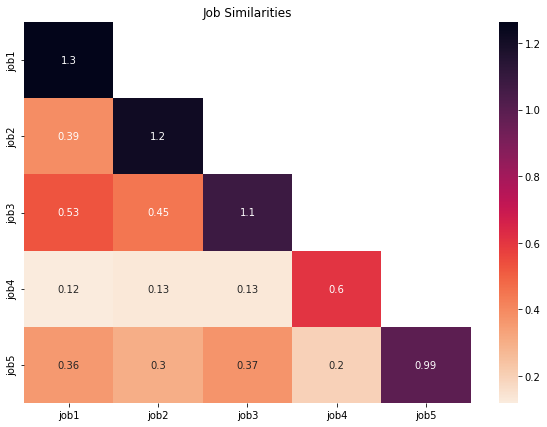

In [47]:
eval_similarity(sim_matrix, job_labels)

**Ergebnis:**

Die Ähnlichkeiten mit diesem Verfahren sind nicht wie gewünscht. Generell sind die Ähnlichkeiten sehr gering.<br>
So werden Job 3 und Job 1 als ähnlich deklariert und die Jobs 3-5 nicht.

---

### **Experiment 6:** Ähnlichkeit der Job-Titel mit Word2vec

In diesem Experiment soll die Ähnlichkeit der Stellenausschreibungen mithilfe des Word2Vec-Distanz der Job-Titeln evaluiert werden. 

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

Load the title of these jobs

In [48]:
job1_title = data['job_title'][0]    # farmer
job2_title = data['job_title'][3]    # finance -> inevsting, black rock
job3_title = data['job_title'][4]    # data science -> analytics
job4_title = data['job_title'][2]    # data science -> machine learning
job5_title = data['job_title'][1]

titles_ = [job1_title, job2_title, job3_title, job4_title, job5_title]

Take in SpaCy Pipeline to get Word2Vec value

In [49]:
nlp = spacy.load("en_core_web_lg")

doc_titles = [nlp(title) for title in titles_]
labels = ["job1", "job2", "job3", "job4", "job5"]

Evaluate

In [50]:
sim_matrix = create_similarity_matrix(lambda x,y: x.similarity(y), doc_titles)

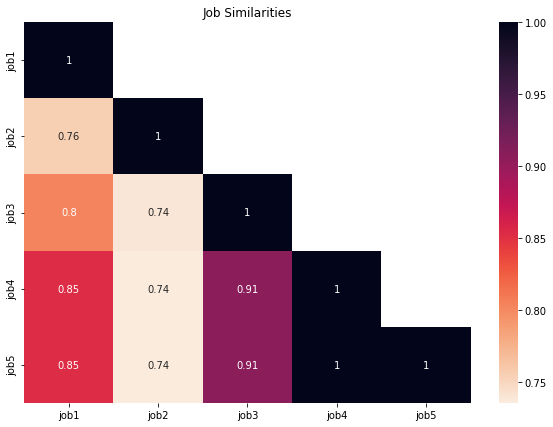

In [51]:
eval_similarity(sim_matrix, labels)

**Ergebnis:**

Das Verfahren zeigt recht gute Ergebnisse. Die Jobs 3-5 werden als ähnlich gekennzeichnet. Währendessen ist die Ähnlichkeit zu dem 2.ten Job der Jobs 3-5 merkbar geringer. Ebenso wird die Unähnlichkeit der Jobs 1 und 2 erkannt.<br>
<br>
Die einzige Schwäche ist die Ähnlichkeit von Job 1 und den jobs 3-5. Die Ähnlichkeit ist hier zwar etwas geinger, jedoch nicht so stark.

---

### **Experiment 7:** Ähnlichkeit der Job-Kategorien

In diesem Experiment soll die Ähnlichkeit der Stellenausschreibungen mithilfe der Kategorie des Jobs berechnet werden.

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

Load the city of these jobs

In [52]:
job1_category = data['category'][0]    # farmer
job2_category = data['category'][3]    # finance -> inevsting, black rock
job3_category = data['category'][4]    # data science -> analytics
job4_category = data['category'][2]    # data science -> machine learning
job5_category = data['category'][1]

categories_ = [job1_category, job2_category, job3_category, job4_category, job5_category]

In [53]:
nlp = spacy.load("en_core_web_lg")

#doc_categories = [nlp(category) for category in categories_ ]
labels = ["job1", "job2", "job3", "job4", "job5"]

In [54]:
categories_

['Accounting/Finance', 'Accounting/Finance', 'biotech', nan, nan]

In [55]:
# should run, if there where no nans
#sim_matrix = create_similarity_matrix(lambda x,y: x.similarity(y), doc_categories)
#eval_similarity(sim_matrix, labels)

Fixing Nan values

In [56]:
data.shape[0] / data['category'].isna().sum()

11.337868480725623

In [57]:
def get_most_common_noun(nlp, job_description):
    doc = nlp(job_description)
    words = dict()
    for token in doc:
        if token.pos_ in ["NOUN", "PROPN"]:
            if token.text in words.keys():
                words[token.text] += 1
            else:
                words[token.text] = 1
    return sorted(words.items(), key=lambda x:x[0])[0][0]           

In [58]:
get_most_common_noun(nlp, jobs_[4])

'Algorithms'

In [59]:
get_most_common_noun(nlp, jobs_[1])

'@blackrock'

In [60]:
# if no category -> find category
# get most common noun
fixed_categories_ = []
for i, category in enumerate(categories_):
    if type(category) == float:
        # overwrite it
        fixed_categories_ += [get_most_common_noun(nlp, jobs_[i])]
    else:
        fixed_categories_ += [category]

Take in SpaCy Pipeline to get Word2Vec value

In [61]:
nlp = spacy.load("en_core_web_lg")

doc_categories = [nlp(category) for category in fixed_categories_]
labels = ["job1", "job2", "job3", "job4", "job5"]

In [62]:
fixed_categories_

['Accounting/Finance', 'Accounting/Finance', 'biotech', 'Apache', 'Algorithms']

Evaluate

In [63]:
sim_matrix = create_similarity_matrix(lambda x,y: x.similarity(y), doc_categories)

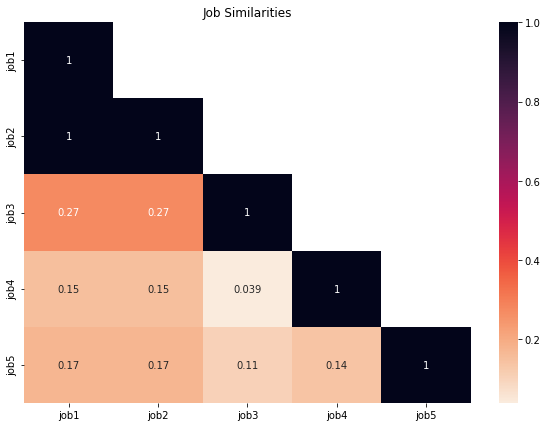

In [64]:
eval_similarity(sim_matrix, labels)

**Ergebnis:**

Das Verfahren scheint nicht ganz zu funktionieren. Die Jobs 1 & 2 wurden als ähnlich deklariert, was gut ist. Die 3 Data Science Berufe jedoch gar nicht. Damit ist dieses Verfahren so erstmal nur zum Teil hilfreich.<br>
<br>
Es könnte so implementiert werden, dass bei ähnlicher Job-Kategorie Bonuspunkte vergeben werden (siehe letztes Experiment). Es muss jedoch bedacht werden, dass viele ähnliche Job-Kategorien nicht gefunden werden! Hier sind die Bezeichnungen zu unterschiedlich.

---

### **Experiment 8:** Ähnlichkeit der Job-Orte

In diesem Experiment soll die Ähnlichkeit der Stellenausschreibungen mithilfe der Ortsdistanz berechnet werden.

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In [65]:
[(data.iloc[job_con[i],5], data.iloc[job_con[i], 7])  for i in ['job1', 'job2', 'job3', 'job4', 'job5']]

[('Woodland Hills', 'Usa'),
 ('New York', 'Usa'),
 ('Charlotte', 'Usa'),
 ('New York', 'Usa'),
 ('Middletown', 'Usa')]

Optimales Ergebnis:

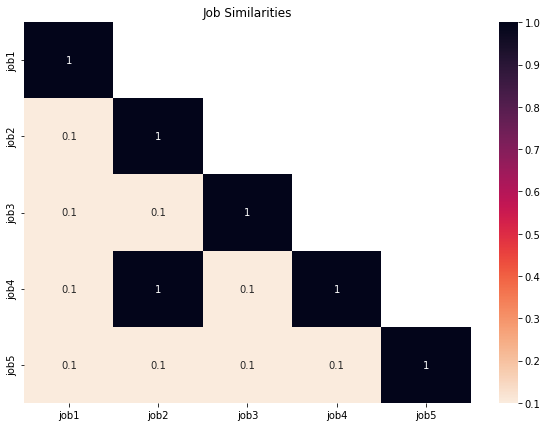

In [66]:
template = [[1, 0.1, 0.1, 0.3, 0.3], 
           [0.1, 1, 0.1, 0.3, 0.3],
           [0.1, 0.1, 1, 0.95, 0.95],
           [0.1, 1.0, 0.1, 1, 0.95],
           [0.1, 0.1, 0.1, 0.1, 1.0]]
eval_similarity(template, ["job1", "job2", "job3", "job4", "job5"])

Load the city of these jobs

In [67]:
job1_city = data['city'][0]    # farmer
job2_city = data['city'][3]    # finance -> inevsting, black rock
job3_city = data['city'][4]    # data science -> analytics
job4_city = data['city'][2]    # data science -> machine learning
job5_city = data['city'][1]

cities_ = [job1_city, job2_city, job3_city, job4_city, job5_city]
labels = ["job1", "job2", "job3", "job4", "job5"]

In [68]:
job1_country = data['country'][0]    # farmer
job2_country = data['country'][3]    # finance -> inevsting, black rock
job3_country = data['country'][4]    # data science -> analytics
job4_country = data['country'][2]    # data science -> machine learning
job5_country = data['country'][1]

countries_ = [job1_country, job2_country, job3_country, job4_country, job5_country]

In [69]:
def find_pos(city, country):
    # Initialize Nominatim API
    geolocator = Nominatim(user_agent="MyApp")

    location = geolocator.geocode(f"{city} {country}", language="en")
    return location.latitude, location.longitude

In [70]:
find_pos("paris", "france")

(48.8588897, 2.3200410217200766)

In [71]:
positions = []
for job in range(5):
    positions += [find_pos(cities_[job], countries_[job])]

In [72]:
positions

[(34.1684364, -118.6058382),
 (40.7127281, -74.0060152),
 (35.2272086, -80.8430827),
 (40.7127281, -74.0060152),
 (41.5623178, -72.6509061)]

In [73]:
calc_dist = lambda pos1, pos2:1/(geodesic(pos1, pos2).km+1)

In [74]:
sim_matrix = create_similarity_matrix(calc_dist, positions)

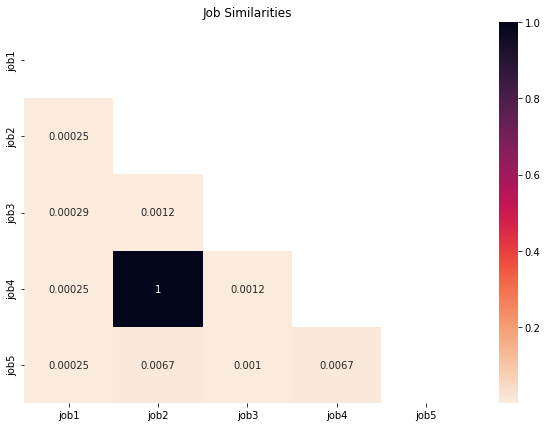

In [75]:
eval_similarity(sim_matrix, labels, k=0)

Now evaluate it

In [76]:
pos_ = [["freiburg", "germany"], ["emmendingen", "germany"], ["offenburg", "germany"], ["berlin", "germany"]]
labels_ = ["freiburg", "emmendingen", "offenburg", "berlin"]
pos = []
for city, country in pos_:
    pos += [find_pos(city, country)]

In [77]:
pos

[(47.9960901, 7.8494005),
 (48.1342091, 7.862308289129789),
 (48.4716556, 7.944378),
 (52.5170365, 13.3888599)]

In [78]:
sim_matrix = create_similarity_matrix(calc_dist, pos)

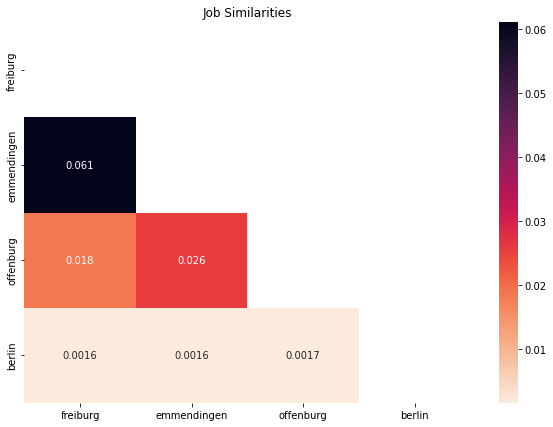

In [79]:
eval_similarity(sim_matrix, labels_, k=0)

Next step is from the distance to a similarity value:

In [80]:
def dist_sim(pos1, pos2):
    sim = 1 / (geodesic(pos1, pos2).km+1)

    if sim >= 0.1:
        return 0.95
    elif sim >= 0.07:
        return 0.85
    elif sim >= 0.03:
        return 0.75
    elif sim >= 0.01:
        return 0.65
    else:
        return 0.01

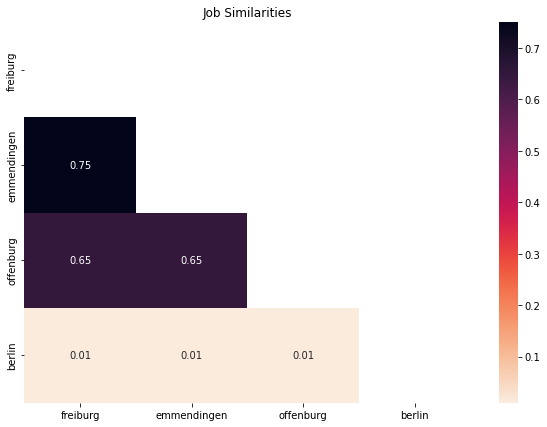

In [81]:
sim_matrix = create_similarity_matrix(dist_sim, pos)
eval_similarity(sim_matrix, labels_, k=0)

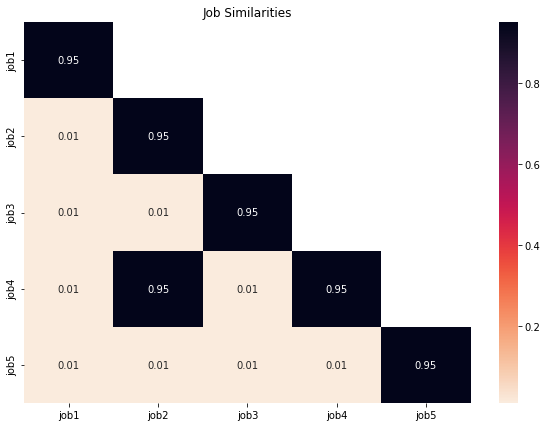

In [82]:
sim_matrix = create_similarity_matrix(dist_sim, positions)
eval_similarity(sim_matrix, labels, k=1)

Revert der Ähnlicheit, falls jemand es weiter Weg bevorzugt

In [83]:
def revert_sim(sim:float):
    return round((sim*-1)+1.0, 2)

In [84]:
it_works = True
falses = []
for i, j in [(0.1, 0.9), (0.9, 0.1), (0.2, 0.8), (0.8, 0.2), (0.25, 0.75), (0.75, 0.25), (0.5, 0.5)]:
    if revert_sim(i) != j:
        it_works = False
        falses += [(i, j, revert_sim(i))]

if it_works:
    print("Yeah, it works!")
else:
    print("Nope it doesn't work at all...")
    print(f"Wrong ones: {falses}")

Yeah, it works!


In [85]:
def dist_sim_revert(pos1, pos2):
    return revert_sim(dist_sim(pos1, pos2))

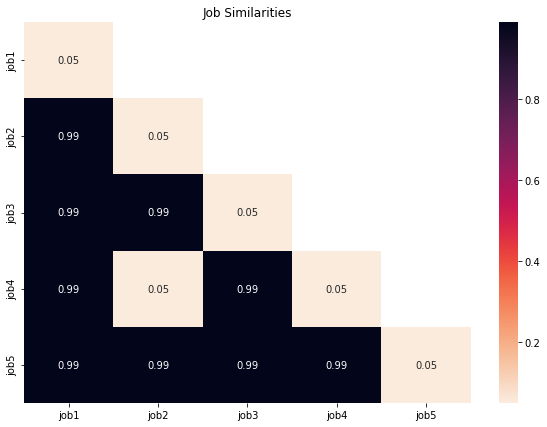

In [86]:
sim_matrix = create_similarity_matrix(dist_sim_revert, positions)
eval_similarity(sim_matrix, labels, k=1)

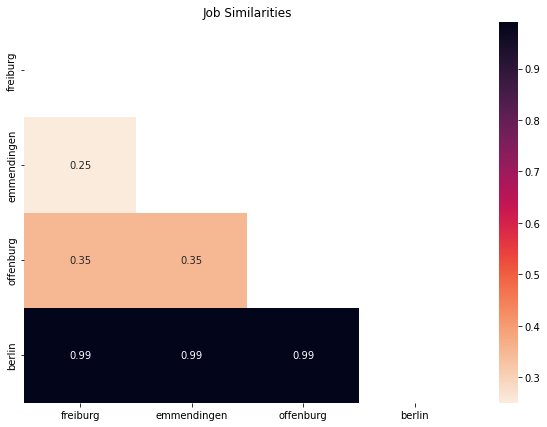

In [87]:
sim_matrix = create_similarity_matrix(dist_sim_revert, pos)
eval_similarity(sim_matrix, labels_, k=0)

**Ergebnis:**

Mit diesem Verfahren lassen sich nun die Distanzen berechnen und so nahe Jobangebote finden, falls das gesucht ist. Dabei scheint das Verfahren so funktionieren, wie erhofft.<br>
<bR>
Die Evaluierung zeigt zudem, dass dieser Prozess auch wiklich funktioniert. Freiburg und Emmendingen sind sich am nähesten. Emmendingen ist näher an Offenburg als Freiburg. Und Berlin ist von allen drein weit weg. <br>
<br>
Trotzdem bleibt dieser Faktor etwas schwierig, da die Distanz auch Subjektiv ist und es auch Menschen geben könnte, welche gerne Wegziehen würden.<br>
Hierfür kann man die revert-Funktion verwenden, die nauch funktioniert, was die Evaluierung zeigt.

---

### **Experiment 9:** Ähnlichkeit der Job-Art

In diesem Experiment soll die Ähnlichkeit der Stellenausschreibungen mithilfe der Berufsart festgestellt werden.<br>Umgesetzt durch Regeln.

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In [88]:
[data.iloc[job_con[i], 13] for i in ['job1', 'job2', 'job3', 'job4', 'job5']]

['Undefined', 'Undefined', 'Full Time', 'Full Time', 'Undefined']

In [89]:
data['job_type'].unique()

array(['Undefined', 'Full Time', 'Contract', 'Part Time', 'Internship'],
      dtype=object)

Optimales Ergebnis:

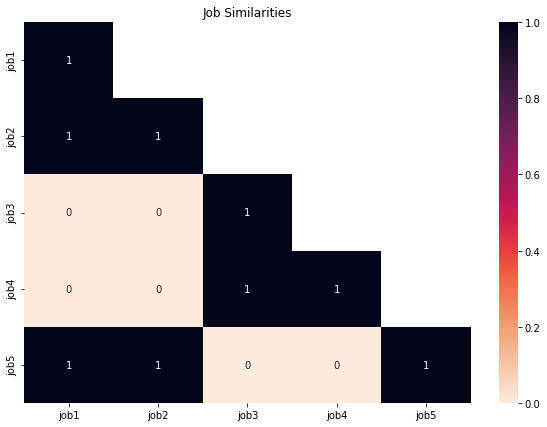

In [90]:
template = [[1, 0.1, 0.1, 0.3, 0.3], 
           [1.0, 1, 0.1, 0.3, 0.3],
           [0.0, 0.0, 1, 0.95, 0.95],
           [0.0, 0.0, 1.0, 1, 0.95],
           [1.0, 1.0, 0.0, 0.0, 1.0]]
eval_similarity(template, ["job1", "job2", "job3", "job4", "job5"])

Load the types.

In [91]:
job1_type = data['job_type'][0]    # farmer
job2_type = data['job_type'][3]    # finance -> inevsting, black rock
job3_type = data['job_type'][4]    # data science -> analytics
job4_type = data['job_type'][2]    # data science -> machine learning
job5_type = data['job_type'][1]

types_ = [job1_type, job2_type, job3_type, job4_type, job5_type]
labels = ["job1", "job2", "job3", "job4", "job5"]

In [92]:
data['job_type'].value_counts()

Undefined     6109
Full Time     3395
Contract       488
Part Time        6
Internship       2
Name: job_type, dtype: int64

In [93]:
def type_sim(type1, type2):
    res = 0.0    

    if type1 == type2:
        res = 1.0
    elif (type1 == "Full Time" and type2 == "Contract") or (type2 == "Full Time" and type1 == "Contract"):
        res = 0.5
    elif (type1 == "Part Time" and type2 == "Full Time") or (type2 == "Part Time" and type1 == "Full Time"):
        res = 0.5
    elif (type1 == "Part Time" and type2 == "Internship") or (type2 == "Part Time" and type1 == "Internship"):
        res = 0.2
    elif (type1 == "Part Time" and type2 == "Contract") or (type2 == "Part Time" and type1 == "Contract"):
        res = 0.5
    elif (type1 == "Full Time" and type2 == "Internship") or (type2 == "Full Time" and type1 == "Internship"):
        res = 0.0
    elif (type1 == "Contract" and type2 == "Internship") or (type2 == "Contract" and type1 == "Internship"):
        res = 0.5
    elif type1 == "Undefined" or type2 == "Undefined":
        res = 0.1
    return res

Evaluate

In [94]:
sim_matrix = create_similarity_matrix(type_sim, types_)

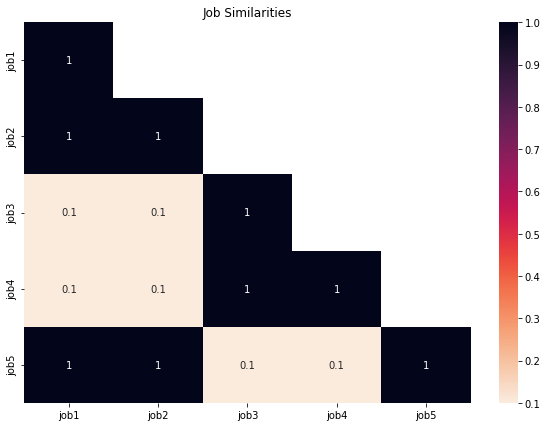

In [95]:
eval_similarity(sim_matrix, labels)

**Ergebnis:**

Die Werte sind um 0.1 zu dem Evaluierungsmaß anders. Dies ist vernachlässigbar, da die Resulte insgesamt die gleichen sind.<bR>
<br>
Durch den regelbasierten Ansatz kann man leicht die Berufe mit der Ähnlichkeit ihres Berufstyps bestimmen. Leider sind jedoch nicht viele gelabelt, was bei der Anwendung bedacht werden muss. 

---

### **Experiment 10:** Point-Gain-Proceedings

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

Es sollen mehere Ansätze gewichtet kombiniert werden. Dies resultiert daraus, dass angenommen wird, dass die Ähnlichkeit subjektiv ist und somit variieren kann (Schwerpunkte festgelegt werden können).<br>
So ein Ansatz soll hier evaluiert werden.<br>
<br>
Bei dem Ansatz werden Punkte vergeben und umso mehr Punkte ein Job hat, desto ähnlicher soll dieser dem Zieljob sein. Dabei ist es nicht so schlimm, dass in manchen Kategorien kein Wert steht, da es hierfür nun einfach keine zusätzlichen Punkte gibt und das Jobausschreibung trotzdem noch als ähnlich gesehen werden kann.<br>
<br>
Außerdem kann man durch dieses Verfahren leicht Schwerpunkte setzen.<br>
<br>
Dieses Experiment wird direkt so programmiert, dass es später leicht einzusetzen ist.
<br>
<br>
> Vorgehen = Jede Kategorie gibt 0-5 Punkte und mithilfe der Parameter kann man diese Punktzahl gewichten um Schwerpunkte zu setzen

Eingabe ist eine Liste mit folgenden Einträgen und die Liste repräsentiert ein Job Post:

<img src="./cols.png" width=170></img>

Programmierung der Komponenten und des Algorithmus:

In [96]:
def job_title_points(nlp, title1, title2):
    doc1 = nlp(title1)
    doc2 = nlp(title2)
    sim = doc1.similarity(doc2)
    
    if sim >= 0.95:
        return 5
    elif sim >= 0.9:
        return 4
    elif sim >= 0.8:
        return 2
    elif sim >= 0.7:
        return 1
    else:
        return 0

In [105]:
def job_category_points(nlp, category1, category2, description1, description2):
    # fix the category if it nothing
    if type(category1) == float:
        category1 = get_most_common_noun(nlp, description1)
        
    if type(category2) == float:
        category2 = get_most_common_noun(nlp, description2)
        
    # build doc
    doc1 = nlp(category1)
    doc2 = nlp(category2)
    
    # calc similarity
    sim = doc1.similarity(doc2)
    
    if sim >= 0.95:
        return 5
    elif sim >= 0.9:
        return 3
    elif sim >= 0.8:
        return 1
    else:
        return 0

In [98]:
def revert_sim(sim:float):
    return round((sim*-1)+1.0, 2)

In [99]:
def job_type_points(type1, type2):
    res = 0.0    

    if type1 == type2:
        res = 1.0
    elif (type1 == "Full Time" and type2 == "Contract") or (type2 == "Full Time" and type1 == "Contract"):
        res = 0.5
    elif (type1 == "Part Time" and type2 == "Full Time") or (type2 == "Part Time" and type1 == "Full Time"):
        res = 0.5
    elif (type1 == "Part Time" and type2 == "Internship") or (type2 == "Part Time" and type1 == "Internship"):
        res = 0.2
    elif (type1 == "Part Time" and type2 == "Contract") or (type2 == "Part Time" and type1 == "Contract"):
        res = 0.5
    elif (type1 == "Full Time" and type2 == "Internship") or (type2 == "Full Time" and type1 == "Internship"):
        res = 0.0
    elif (type1 == "Contract" and type2 == "Internship") or (type2 == "Contract" and type1 == "Internship"):
        res = 0.5
    elif type1 == "Undefined" or type2 == "Undefined":
        res = 0.1
    return res

In [106]:
def job_location_points(city1, country1, city2, country2, weight):
    # Initialize Nominatim API
    geolocator = Nominatim(user_agent="MyApp")

    location1 = geolocator.geocode(f"{city1} {country1}", language="en")
    location2 = geolocator.geocode(f"{city2} {country2}", language="en")
    
    if location1 == None or location2 == None:
        return 0
    
    pos1 = (location1.latitude, location1.longitude)
    pos2 = (location2.latitude, location2.longitude)
    
    sim = 1 / (geodesic(pos1, pos2).km+1)

    if weight < 0:
        sim = revert_sim(sim)
    
    if sim >= 0.1:
        return 5
    elif sim >= 0.07:
        return 4
    elif sim >= 0.03:
        return 3
    elif sim >= 0.01:
        return 1
    else:
        return 0

In [102]:
# all categories gets between 0-5 points
def get_similar_job_posts(job_posts:pd.DataFrame, job_post:list, min_points=5, pruning=False, \
                                  title_w=2.0, category_w=1.0, type_w=1.0, pos_w=0.5, printing=True):
    
    # load other job posts 
    #all_job_posts = pd.read_excel("../data_scientist_united_states_job_postings_jobspikr.xlsx")
    all_job_posts = job_posts
    # create score-list
    #all_job_posts['score'] = 0.0
    score = np.array([0]*len(all_job_posts))
    
    # calc points
    nlp = spacy.load("en_core_web_lg")
    for post_idx in range(len(all_job_posts)):
        if printing: print(f"Calculate post {post_idx}...")
        # points for job-title similarity
        if title_w != 0:
            score[post_idx] += job_title_points(nlp, job_post[2], all_job_posts.loc[post_idx, :]['job_title']) * title_w
        
        # pruning -> if 0 points at the first, than skip
        if pruning and score[post_idx] == 0:
            continue
            
        # points for job-category similarity
        if category_w != 0:
            score[post_idx] += job_category_points(nlp, job_post[3], all_job_posts['category'][post_idx], \
                                               job_post[12], all_job_posts['job_description'][post_idx]) * category_w
        
        # points for job-type similarity  
        if type_w != 0:
            score[post_idx] += job_type_points(job_post[13], all_job_posts['job_type'][post_idx]) * type_w
        
        
        # points for job-location similarity  
        if pos_w != 0:
            score[post_idx] += job_location_points(job_post[5], job_post[7], all_job_posts['city'][post_idx], \
                                               all_job_posts['country'][post_idx], pos_w) * abs(pos_w)
        
    
    
    
    # return all posts with more than x points
    all_job_posts.loc[:, ['score']] = score
    return all_job_posts[all_job_posts['score'] >= min_points].sort_values(by="score", ascending=False)

**Evaluation**

In [103]:
#post_id = np.random.randint(0, len(data))
post_id = 33
post = data.values.tolist()[post_id]
post

[Timestamp('2019-02-06 08:30:12'),
 'https://www.careerbuilder.com/job/J3M2F963CC5895ZY3P0',
 'Senior Data Scientist - Tallahassee, FL - $150k-$170k',
 'business and financial operations',
 'Jefferson Frank',
 'Tallahassee',
 'FL',
 'Usa',
 'Tallahassee',
 'Florida',
 'Usa',
 Timestamp('2019-02-05 00:00:00'),
 'My client is a leader in the Manufacturing vertical and has operations in multiple states across the US. They are seeking to hire a full-time Senior Data Scientist to collaborate and work with their R&D, IT, Product Support, and Sales teams. Ideal Candidates Will Have: -Multiple years of Business Intelligence with the ability to work with structured and unstructured data -Multiple years of programming with C, C++, Java, or JavaScript languages -Experience working with AWS Services such as Redshift, S3, Athena, Kinesis My client has already begun interviewing candidates and is seeking to hire quickly. If interested call Mike @ 813-437-6882 and email your CV to m.greco@jeffersonfr

In [107]:
#data.sample(n=50, replace=False)
res = get_similar_job_posts(data.head(50), post, title_w=2.0, category_w=1.0, type_w=1.0, pos_w=0.5)

Calculate post 0...
Calculate post 1...
Calculate post 2...
Calculate post 3...
Calculate post 4...
Calculate post 5...
Calculate post 6...
Calculate post 7...


C:\Users\tobia\AppData\Local\Temp\ipykernel_19840\1465696467.py:14: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim = doc1.similarity(doc2)


Calculate post 8...
Calculate post 9...
Calculate post 10...
Calculate post 11...
Calculate post 12...
Calculate post 13...
Calculate post 14...
Calculate post 15...
Calculate post 16...
Calculate post 17...
Calculate post 18...
Calculate post 19...
Calculate post 20...
Calculate post 21...
Calculate post 22...
Calculate post 23...
Calculate post 24...
Calculate post 25...
Calculate post 26...
Calculate post 27...
Calculate post 28...
Calculate post 29...
Calculate post 30...
Calculate post 31...
Calculate post 32...
Calculate post 33...
Calculate post 34...
Calculate post 35...
Calculate post 36...
Calculate post 37...
Calculate post 38...
Calculate post 39...
Calculate post 40...
Calculate post 41...
Calculate post 42...
Calculate post 43...
Calculate post 44...
Calculate post 45...
Calculate post 46...
Calculate post 47...
Calculate post 48...
Calculate post 49...


C:\Users\tobia\AppData\Local\Temp\ipykernel_19840\3777288938.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_job_posts.loc[:, ['score']] = score


In [108]:
res.head()

,crawl_timestamp,url,job_title,category,company_name,city,state,country,inferred_city,inferred_state,...,job_type,salary_offered,job_board,geo,cursor,contact_email,contact_phone_number,uniq_id,html_job_description,score
33,2019-02-06 08:30:12,https://www.careerbuilder.com/job/J3M2F963CC58...,"Senior Data Scientist - Tallahassee, FL - $150...",business and financial operations,Jefferson Frank,Tallahassee,FL,Usa,Tallahassee,Florida,...,Full Time,NaN,careerbuilder,usa,1549440025100072,NaN,813 437 6882,d33577ea9ae09c58d77e1fab2c012ba2,NaN,18
38,2019-02-06 08:31:04,https://www.careerbuilder.com/job/J3V7V35YMD61...,"Data Scientist Tampa, FL $110-130K",business and financial operations,Jefferson Frank,Tampa,FL,Usa,Tampa,Florida,...,Full Time,NaN,careerbuilder,usa,1549440025192604,NaN,813 437 6899 (ext 6899),acfd50bf4d44eb476ec69b38348355be,NaN,10
32,2019-02-06 08:30:24,https://www.careerbuilder.com/job/J3P7X86X5NNW...,Data Scientist,business and financial operations,Apex Systems,West Chester Township,OH,Usa,West chester,Ohio,...,Full Time,NaN,careerbuilder,usa,1549440025093739,NaN,NaN,b6e361550638f071a4985bf5f3d440ce,NaN,6
34,2019-02-06 08:28:00,https://www.careerbuilder.com/job/J2Y3W15X0M6C...,Data Scientist,business and financial operations,"5 Star Global Recruitment Partners, LLC",Dallas,TX,Usa,Dallas,Texas,...,Full Time,NaN,careerbuilder,usa,1549440025102978,NaN,256-651-8116,09378ddde9b997b1acbf519c2b9ddf03,NaN,6
35,2019-02-06 08:27:37,https://www.careerbuilder.com/job/J3R3TB6LYHFY...,Data Scientist,business and financial operations,IQVIA,Plymouth Meeting,PA,Usa,Plymouth meeting,Pennsylvania,...,Full Time,NaN,careerbuilder,usa,1549440025119178,NaN,NaN,eb3e1cdd65a86ef8b4cf28094f0c785b,NaN,6


**Ergebnis:**

Das Punktesystem scheint zu funktionieren und es ist möglich seine Auswahl zu gewichten und damit andere optimale Jobangebote zu finden. <br>
Im obigen Beispiel wurden ebenfalls erst Data Science Stellenanzeigen gezeigt, welche im Bereich der Finanzen sind. Und bei Reduzierung der Gewichtung, war dies nicht mehr so. Somit hat der Ansatz funktioniert.<br>
<br>
An dieser Variante ist ebenfalls schön, dass sie leicht zu erweitern ist.<br>
<br>
Leider hat sich das Verfahren als sehr unperformant erwiesen. Im Experiment wurde ersichtlich, dass dies nicht nur an den Berechnungen an sich liegt, sondern vor allem an der großen Anzahl an Job-Posts.

---

### Experiment 11: Paralleles Ausführen
[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)
Ziel ist es die Ausführung performanter zu gestalten. Hierzu 2 Gedanken:
- Reduzierung der Daten (random Wahl)
- Paralleles Ausführen

In diesem Experiment wird die Performancesteigerung durch Threading evaluiert.

Folgendes wurde probiert, hat jedoch nicht funktioniert:
- multiprocessing -> windows collaps -> memory out of memory
- dask apply -> nein, dafür zu viele funktionen
- threading -> ja


In [109]:
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sn

import spacy
from spacy.tokens import Token

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

import multiprocessing as mp
from threading import Thread



def get_most_common_noun(job_description):
    nlp = spacy.load("en_core_web_lg")
    doc = nlp(job_description)
    words = dict()
    for token in doc:
        if token.pos_ in ["NOUN", "PROPN"]:
            if token.text in words.keys():
                words[token.text] += 1
            else:
                words[token.text] = 1
    return sorted(words.items(), key=lambda x:x[0])[0][0]           



def job_title_points(nlp, title1, title2):
    doc1 = nlp(title1)
    doc2 = nlp(title2)
    sim = doc1.similarity(doc2)
    
    if sim >= 0.95:
        return 5
    elif sim >= 0.9:
        return 4
    elif sim >= 0.8:
        return 2
    elif sim >= 0.7:
        return 1
    else:
        return 0



def job_category_points(nlp, category1, category2, description1, description2, weight):
    # fix the category if it nothing
    if type(category1) == float:
        category1 = get_most_common_noun(description1)
        
    if type(category2) == float:
        category2 = get_most_common_noun(description2)
        
    # build doc
    doc1 = nlp(category1)
    doc2 = nlp(category2)
    
    # calc similarity
    sim = doc1.similarity(doc2)

    if weight < 0:
        sim = revert_sim(sim)
    
    if sim >= 0.95:
        return 5
    elif sim >= 0.9:
        return 3
    elif sim >= 0.8:
        return 1
    else:
        return 0



def job_type_points(type1, type2):
    res = 0.0    

    if type1 == type2:
        res = 1.0
    elif (type1 == "Full Time" and type2 == "Contract") or (type2 == "Full Time" and type1 == "Contract"):
        res = 0.5
    elif (type1 == "Part Time" and type2 == "Full Time") or (type2 == "Part Time" and type1 == "Full Time"):
        res = 0.5
    elif (type1 == "Part Time" and type2 == "Internship") or (type2 == "Part Time" and type1 == "Internship"):
        res = 0.2
    elif (type1 == "Part Time" and type2 == "Contract") or (type2 == "Part Time" and type1 == "Contract"):
        res = 0.5
    elif (type1 == "Full Time" and type2 == "Internship") or (type2 == "Full Time" and type1 == "Internship"):
        res = 0.0
    elif (type1 == "Contract" and type2 == "Internship") or (type2 == "Contract" and type1 == "Internship"):
        res = 0.5
    elif type1 == "Undefined" or type2 == "Undefined":
        res = 0.1
    return res



def job_location_points(city1, country1, city2, country2):
    # Initialize Nominatim API
    geolocator = Nominatim(user_agent="MyApp")

    location1 = geolocator.geocode(f"{city1} {country1}", language="en", timeout=10000)
    location2 = geolocator.geocode(f"{city2} {country2}", language="en", timeout=10000)
    
    if location1 == None or location2 == None:
        return 0
    
    pos1 = (location1.latitude, location1.longitude)
    pos2 = (location2.latitude, location2.longitude)
    
    sim = 1 / (geodesic(pos1, pos2).km+1)
    
    if sim >= 0.1:
        return 5
    elif sim >= 0.07:
        return 4
    elif sim >= 0.03:
        return 3
    elif sim >= 0.01:
        return 1
    else:
        return 0



def log(txt:str, should_show=False):
    if should_show: print("\n"+txt+"\n")



def calc_points(result, job_posts:pd.DataFrame, job_post, progress, total, nlp, pruning, title_w, category_w, type_w, pos_w, printing):
    
    # create score-list
    score = np.array([0]*len(job_posts))

    offset = job_posts.index.start
    
    for post_idx in range(len(job_posts)):
        #if printing: print(f"Calculate post {post_idx}...")
        # points for job-title similarity
        if title_w != 0:
            score[post_idx] += job_title_points(nlp, job_post[2], job_posts.loc[post_idx+offset, :]['job_title']) * title_w

        # pruning -> if 0 points at the first, than skip
        if pruning and score[post_idx] == 0:
            continue

        # points for job-category similarity
        if category_w != 0:
            score[post_idx] += job_category_points(nlp, job_post[3], job_posts['category'][post_idx+offset], \
                                            job_post[12], job_posts['job_description'][post_idx+offset]) * category_w

        # points for job-type similarity  
        if type_w != 0:
            score[post_idx] += job_type_points(job_post[13], job_posts['job_type'][post_idx+offset]) * type_w


        # points for job-location similarity  
        if pos_w != 0:
            score[post_idx] += job_location_points(job_post[5], job_post[7], job_posts['city'][post_idx+offset], \
                                            job_posts['country'][post_idx+offset], pos_w) * abs(pos_w)

        progress[0] += 1
        progress_bar(progress[0], total)

    # return all posts with more than x points
    job_posts.loc[:, ['score']] = score
    log(f"One Process finished!", printing)
    result += [job_posts]
    #return job_posts


# all categories gets between 0-5 points
def get_similar_job_posts_parallel(job_posts:pd.DataFrame, job_post:list, min_points=5, pruning=False, \
                                  title_w=2.0, category_w=1.0, type_w=1.0, pos_w=0.5, printing=True, thread_amount=2):
    log_sym = "x"
    # load other job posts 
    all_job_posts = job_posts
    
    # split
    n = thread_amount   #mp.cpu_count()
    log(f"Splitting data into {n} portions...", printing)
    max_ = len(all_job_posts)//n
    job_post_portions = []
    pointer = 0
    for i in range(n):
        job_post_portions += [all_job_posts.iloc[pointer:pointer+max_, :]]
        pointer += len(all_job_posts)//n
    log(log_sym, printing)
    log(f"Each portion contains {max_} jobposts...", printing)
     
    
    # calc points
    log(f"Loading SpaCy en_core_web_lg corpus...", printing)
    nlp = spacy.load("en_core_web_lg")
    log(log_sym, printing)
    
    # start processes / calc parallel the points / similarity
    log(f"Starts parallel calculation of the similarity/points with {n} Threads...", printing)
    progress = [0]    # use this for changing
    total = job_posts.shape[0]
    args = (job_post, progress, total, nlp, pruning, title_w, category_w, type_w, pos_w, printing)
    results = []
    threads = []
    for jobs in job_post_portions:
        t = Thread(target=calc_points, args=(results, jobs,)+args)
        threads += [t]
        t.start()
    #log(log_sym, printing)
    #log(f"Created Threads and they running...\n", printing)

    # wait until finishes
    #log(f"Waiting for finishing tasks...", printing)
    for t in threads: 
        t.join()
    log(log_sym, printing)
    log(f"Finished with the parallel calculation of the similarity/points...\n", printing)
    
    # merge
    log(f"Merging scored job posts...", printing)
    if len(results) > 0:
        scored_job_posts = results[0]
        for result in results[1:]:
            scored_job_posts.append(result, ignore_index=True)
        log(log_sym, printing)
        
        # take only important results and sort them
        log(f"Sorting scored job posts...", printing)
        r = scored_job_posts[scored_job_posts['score'] >= min_points].sort_values(by="score", ascending=False)
        log(log_sym, printing)
        return r


def get_number_input(msg:str, min=None, max=None):
    wrong_input = True
    while wrong_input:
        #addition = ""
        #if min != None:
        #    addition += f"(min={min})"
        #if max != None:
        #    if min != None:
        #        addition += ", "
        #    addition += f"(max={max})"
        user_input = input(f"{msg}:")#+addition

        if user_input == "exit":
            sys.exit()

        try:
            result = int(user_input)
            if min != None and max != None:
                if result >= min and result <= max:
                    wrong_input = False
                else:
                    print("Try again. Type a number.")# + addition)
            elif min != None and max == None:
                if result >= min:
                    wrong_input = False
                else:
                    print("Try again. Type a number.")
            elif min == None and max != None:
                if result <= max:
                    wrong_input = False
                else:
                    print("Try again. Type a number.")
        except ValueError:
            pass
    return result


def print_job_post(job_post):
    width = 64
    job_str = f"\n{'-'*width}\n{' '*((width//2)-8)}>>> Job Post <<<\n{'-'*width}\n"
    job_str += f"\n\nTitle: {job_post[2]}\n"
    job_str += f"\nCategory: {job_post[3]}\n"
    job_str += f"\nLocation: {job_post[5]} in {job_post[7]}\n"
    job_str += f"\nType: {job_post[13]}\n"
    job_str += f"\nDespription:\n\n {'-'*width}{job_post[12]}\n{'-'*width}\n\n"
    print(job_str)


def progress_bar(progress, total):
    percentage = 100 * (progress/float(total))
    bar = '#'*int(percentage) + '-'*(100-int(percentage))
    print(f"\r[{bar}] {percentage:.2f}%", end="\r")


def calc_points_experiment(result, job_posts:pd.DataFrame, job_post, time_, progress, total, nlp, pruning, title_w, category_w, type_w, pos_w, printing):
    
    # create score-list
    score = np.array([0]*len(job_posts))

    offset = job_posts.index.start
    
    for post_idx in range(len(job_posts)):
        #if printing: print(f"Calculate post {post_idx}...")
        # points for job-title similarity
        start = time.time()
        if title_w != 0:
            score[post_idx] += job_title_points(nlp, job_post[2], job_posts.loc[post_idx+offset, :]['job_title']) * title_w
        duration = round(time.time() - start, 2)
        time_['title'] += duration

        # pruning -> if 0 points at the first, than skip
        if pruning and score[post_idx] == 0:
            continue

        # points for job-category similarity
        start = time.time()
        if category_w != 0:
            score[post_idx] += job_category_points(nlp, job_post[3], job_posts['category'][post_idx+offset], \
                                            job_post[12], job_posts['job_description'][post_idx+offset]) * category_w
        duration = round(time.time() - start, 2)
        time_['category'] += duration

        # points for job-type similarity  
        start = time.time()
        if type_w != 0:
            score[post_idx] += job_type_points(job_post[13], job_posts['job_type'][post_idx+offset]) * type_w
        duration = round(time.time() - start, 2)
        time_['type'] += duration

        # points for job-location similarity  
        start = time.time()
        if pos_w != 0:
            score[post_idx] += job_location_points(job_post[5], job_post[7], job_posts['city'][post_idx+offset], \
                                            job_posts['country'][post_idx+offset], pos_w) * abs(pos_w)
        duration = round(time.time() - start, 2)
        time_['location'] += duration


        progress[0] += 1
        progress_bar(progress[0], total)

    # return all posts with more than x points
    job_posts.loc[:, ['score']] = score
    log(f"One Process finished!", printing)
    result += [job_posts]



# all categories gets between 0-5 points
def get_similar_job_posts_experiment(job_posts:pd.DataFrame, job_post:list, min_points=5, pruning=False, \
                                  title_w=2.0, category_w=1.0, type_w=1.0, pos_w=0.5, printing=True, thread_amount=2):
    time_ = {'title':0, 'location':0, 'type':0, 'category':0}
    # load other job posts 
    all_job_posts = job_posts
    
    # split
    n = thread_amount   
    max_ = len(all_job_posts)//n
    job_post_portions = []
    pointer = 0
    for i in range(n):
        job_post_portions += [all_job_posts.iloc[pointer:pointer+max_, :]]
        pointer += len(all_job_posts)//n
     
    # calc points
    nlp = spacy.load("en_core_web_lg")

    # start processes / calc parallel the points / similarity
    progress = [0]    # use this for changing
    total = job_posts.shape[0]
    args = (job_post, time_, progress, total, nlp, pruning, title_w, category_w, type_w, pos_w, printing)
    results = []
    threads = []
    for jobs in job_post_portions:
        t = Thread(target=calc_points_experiment, args=(results, jobs,)+args)
        threads += [t]
        t.start()

    # wait until finishes
    for t in threads: 
        t.join()
    
    # merge
    if len(results) > 0:
        scored_job_posts = results[0]
        for result in results[1:]:
            scored_job_posts.append(result, ignore_index=True)
        
        # take only important results and sort them
        r = scored_job_posts[scored_job_posts['score'] >= min_points].sort_values(by="score", ascending=False)
    return f"   title: {time_['title']} seconds<br>\n   location: {time_['location']} seconds\n   type: {time_['type']} seconds\n   category: {time_['category']} seconds"


def time_experiment():
    data = pd.read_excel("./data_scientist_united_states_job_postings_jobspikr.xlsx")
    post = data.values.tolist()[33]

    results = ""

    for i in [10, 100, 1000, 10000]:
        print(f"Startet {i} samples...")
        results += f"{'-'*64}\nSample Size = {i}\n{'-'*64}\n"
        for n in [1, 2, 5, 10]:
            print("Waiting for geopy...")
            time.sleep(10)
            print(f"Try on {n} Threads...")
            start = time.time()
            output = get_similar_job_posts_experiment(data.head(i), post, title_w=2.0, category_w=0.0, type_w=1.0, pos_w=0.5, printing=False, thread_amount=n)
            duration = time.time()-start
            results += f"\nThreads: {n} needed {duration:.2f} seconds\n{output}\n"
            print(f"\nThreads: {n} needed {duration:.2f} seconds")
        print(f"\n------------\n")

    # saving in file
    with open("./time_experiment_reults.txt", "w") as file:
        file.write(results)
    

def main():
    data = pd.read_excel("./data_scientist_united_states_job_postings_jobspikr.xlsx")
    choose_a_post = False
    while not choose_a_post:
        post_id = get_number_input(f"Type a number between 0 and {data.shape[0]} to choose a job post", 0, data.shape[0]-1)
        
        post = data.values.tolist()[post_id]
        print_job_post(post)
        answer = get_number_input("Is this ok? (1=yes / 0=no)", 0, 1)
        if answer == 1:
            choose_a_post = True


    posts = get_similar_job_posts_parallel(data.head(2), post, title_w=2.0, category_w=0.0, \
                                            type_w=1.0, pos_w=0.5, printing=False)


    cur_idx = 0
    offset = posts.index[0]
    print("-----\nNavigate with 'next', 'prev', 'exit'\n-----")
    while True:
        print_job_post(posts[cur_idx+offset])
        user_input = input("User:")
        if user_input == "next":
            if cur_idx < posts.shape[0]-1:
                cur_idx += 1
        elif user_input == "prev":
            if cur_idx > 0:
                cur_idx -= 1
        elif user_input == "exit":
            print("bye")
            break

**Evaluation**

Es wurde oben ein umfangreiches Experiment der Performance angefertigt und durchgeführt. Dabei wurden verschiedene Größen an Daten mit unterschiedlicher Anzahl an Threads verglichen. 

Folgende Ergbnisse kamen dabei heraus:


----------------------------------------------------------------
Sample Size = 10

----------------------------------------------------------------
<br>
Threads: 1 needed 11.29 seconds<br>
   title: 0.09999999999999999 seconds<br>
   location: 9.540000000000001 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>
<br>
Threads: 2 needed 10.95 seconds<br>
   title: 0.11999999999999998 seconds<br>
   location: 18.689999999999998 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>
<br>
Threads: 5 needed 10.97 seconds<br>
   title: 0.32000000000000006 seconds<br>
   location: 43.14 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>
<br>
Threads: 10 needed 11.14 seconds<br>
   title: 1.1500000000000004 seconds<br>
   location: 69.10999999999999 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>
<br>

----------------------------------------------------------------
Sample Size = 100

----------------------------------------------------------------
<br>
Threads: 1 needed 101.38 seconds<br>
   title: 1.0000000000000007 seconds<br>
   location: 98.57999999999994 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>

Threads: 2 needed 100.93 seconds<br>
   title: 1.0200000000000007 seconds<br>
   location: 197.66000000000005 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>
<br>
Threads: 5 needed 100.94 seconds<br>
   title: 1.2300000000000009 seconds<br>
   location: 491.9500000000004 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>
<br>
Threads: 10 needed 101.42 seconds<br>
   title: 5.389999999999981 seconds<br>
   location: 969.7200000000006 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>

----------------------------------------------------------------
Sample Size = 1000

----------------------------------------------------------------
<br>
Threads: 1 needed 1000.94 seconds<br>
   title: 10.03999999999983 seconds<br>
   location: 988.9200000000056 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>
<br>
Threads: 2 needed 1000.92 seconds<br>
   title: 10.01999999999983 seconds<br>
   location: 1986.7700000000077 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>
<br>
Threads: 5 needed 1001.33 seconds<br>
   title: 11.799999999999793 seconds<br>
   location: 4980.899999999963 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>
<br>
Threads: 10 needed 1000.99 seconds<br>
   title: 10.839999999999813 seconds<br>
   location: 9959.869999999924 seconds<br>
   type: 0.0 seconds<br>
   category: 0.0 seconds<br>


**Ergebnis:**

Die Experimente zeigen, dass die zeitliche Differenz bei 1, 2, 5 oder 10 Threads lediglich beica. 1 Sekunde liegen. Dabei ist auch kein Muster zu erkennen. So brauchen die 5 Threads bei 1000 Daten ca. 1 Sekunde länger als die anderen 3 Verfahren. Bei 100 Daten gehört es jedoch zu den Schnellsten. Die kleinen Differenzen scheinen in keiner Kausalität mit dem Threading zu stehen.

Wie nach der Theorie her vermutet, bringt das Threading also keinen zeitlichen Vorteil. Die zeitlichen Fluktuationen stammen wahrscheinlich von der schwankenden Rechenpower des Laptops.

Jedoch ist etwas anderes sehr schön zu sehen. Die Berechnung für den Ort bzw. dessen Abstand beträgt ca. 99% der Laufzeit bei 1000 Daten. Der Vergleich der Titel beträgt etwa 10 Sekunden, unabhängig von der Anzahl an Daten. <br>
Ohne den Ort wäre der Algorithmus also immer etwa 10 Sekunden schnell, was das Problem löst.

### Evaluation

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

Die Berechnung der Ähnlichlichkeit über die Ähnlichkeit der Jobbeschreibung hat nicht so funktioniert wie gewünscht. Selbst mit Anpassungen scheint es nicht gut die Ähnlichkeit berechnen zu können.<br>
Dafür hat dies über den Job-Titel und der Word2Vec-Technik sehr gut funktioniert.<br>
<br>
Wie das Experiment 10 gezeigt hat, kann man dieses Verfahren in Verbindung mit anderen Ähnlichkeiten einsetzen, um so ein individuelles Ähnlickeitsmaß herstellen zu können. <br>
<br>
Ein größeres Problem ist die Performance. Es existieren nämlich sehr viele Job-Posts und um alle zu verwenden, wird viel Zeit in Anspruch genommen.<br>
Als Lösungsansatz werden nicht alle Daten verwenden (zufällig 1000 der Daten). Multiprocessing/Threading scheinen keine Lösung zu sein.

---
### Anwendung

[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In [110]:
import sys
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import seaborn as sn

import spacy
from spacy.tokens import Token

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

import multiprocessing as mp
from threading import Thread



def get_most_common_noun(job_description, nlp):
    #nlp = spacy.load("en_core_web_lg")
    doc = nlp(job_description)
    words = dict()
    for token in doc:
        if token.pos_ in ["NOUN", "PROPN"]:
            if token.text in words.keys():
                words[token.text] += 1
            else:
                words[token.text] = 1
    return sorted(words.items(), key=lambda x:x[0])[0][0]           



def job_title_points(nlp, title1, title2):
    doc1 = nlp(title1)
    doc2 = nlp(title2) 

    if (doc1.vector_norm) and (doc2.vector_norm):
        try:
            sim = doc1.similarity(doc2)
        except Exception:
            sim = 0.0
    else:
        #print("Title Vector is empty...")
        sim = 0.0
    
    if sim >= 0.95:
        return 5
    elif sim >= 0.9:
        return 4
    elif sim >= 0.8:
        return 2
    elif sim >= 0.7:
        return 1
    else:
        return 0



def job_category_points(nlp, category1, category2, description1, description2):
    if type(category1) == float or type(category2) == float:
        return 0
    # fix the category if it nothing
    #if type(category1) == float:
    #    category1 = get_most_common_noun(description1, nlp)
        
    #if type(category2) == float:
    #    category2 = get_most_common_noun(description2, nlp)
        
    # build doc
    doc1 = nlp(category1)
    doc2 = nlp(category2)
    
    # calc similarity
    sim = doc1.similarity(doc2)
    
    if sim >= 0.95:
        return 5
    elif sim >= 0.9:
        return 3
    elif sim >= 0.8:
        return 1
    else:
        return 0



def job_type_points(type1, type2):
    res = 0.0    

    if type1 == type2:
        res = 1.0
    elif (type1 == "Full Time" and type2 == "Contract") or (type2 == "Full Time" and type1 == "Contract"):
        res = 0.5
    elif (type1 == "Part Time" and type2 == "Full Time") or (type2 == "Part Time" and type1 == "Full Time"):
        res = 0.5
    elif (type1 == "Part Time" and type2 == "Internship") or (type2 == "Part Time" and type1 == "Internship"):
        res = 0.2
    elif (type1 == "Part Time" and type2 == "Contract") or (type2 == "Part Time" and type1 == "Contract"):
        res = 0.5
    elif (type1 == "Full Time" and type2 == "Internship") or (type2 == "Full Time" and type1 == "Internship"):
        res = 0.0
    elif (type1 == "Contract" and type2 == "Internship") or (type2 == "Contract" and type1 == "Internship"):
        res = 0.5
    elif type1 == "Undefined" or type2 == "Undefined":
        res = 0.1
    return res



def job_location_points(city1, country1, city2, country2, weight):
    # Initialize Nominatim API
    geolocator = Nominatim(user_agent="MyApp")

    location1 = geolocator.geocode(f"{city1} {country1}", language="en", timeout=10000)
    location2 = geolocator.geocode(f"{city2} {country2}", language="en", timeout=10000)
    
    if location1 == None or location2 == None:
        return 0
    
    pos1 = (location1.latitude, location1.longitude)
    pos2 = (location2.latitude, location2.longitude)
    
    sim = 1 / (geodesic(pos1, pos2).km+1)

    if weight < 0:
        sim = revert_sim(sim)
    
    if sim >= 0.1:
        return 5
    elif sim >= 0.07:
        return 4
    elif sim >= 0.03:
        return 3
    elif sim >= 0.01:
        return 1
    else:
        return 0


def log(txt:str, should_show=False):
    if should_show: print("\n"+txt+"\n")


def calc_points(job_posts:pd.DataFrame, job_post, progress, total, nlp, pruning, title_w, category_w, type_w, pos_w, printing, show_progress):
    
    # create score-list
    score = np.array([0]*len(job_posts))

    warning_called = False
    
    for post_idx in range(len(job_posts)):  #
        #if printing: print(f"Calculate post {post_idx}...")
        # points for job-title similarity
        # old: job_posts['job_description'][post_idx]
        if title_w != 0:
            score[post_idx] += job_title_points(nlp, job_post[2], job_posts.iloc[post_idx, 2]) * title_w

        # pruning -> if 0 points at the first, than skip
        if pruning and score[post_idx] == 0:
            continue

        # points for job-category similarity
        if category_w != 0:
            score[post_idx] += job_category_points(nlp, job_post[3], job_posts.iloc[post_idx, 3], \
                                            job_post[12], job_posts.iloc[post_idx, 12]) * category_w

        # points for job-type similarity  
        if type_w != 0:
            score[post_idx] += job_type_points(job_post[13], job_posts.iloc[post_idx, 13]) * type_w


        # points for job-location similarity  
        if pos_w != 0:
            if not warning_called:
                print("\nWARNING: CALC LOCATION IS EXPENSIVE!\n")
                warning_called = True
            if pos_w >= 0:
                score[post_idx] += job_location_points(job_post[5], job_post[7], job_posts.iloc[post_idx, 5], \
                                            job_posts.iloc[post_idx, 7], pos_w) * abs(pos_w)

        if show_progress:
            progress[0] += 1
            progress_bar(progress[0], total)

    # return all posts with more than x points
    job_posts.loc[:, ['score']] = score
    log(f"One Process finished!", printing)
    return job_posts


# all categories gets between 0-5 points
def get_similar_job_posts(job_posts:pd.DataFrame, job_post:list, min_points=5, pruning=False, \
                                  title_w=2.0, category_w=1.0, type_w=1.0, pos_w=0.5, printing=True, show_progress=True):

    warnings.filterwarnings("ignore", message=r"\[W008\]", category=UserWarning)

    log_sym = "x"
    # load other job posts 
    all_job_posts = job_posts
    
    # calc points
    log(f"Loading SpaCy en_core_web_lg corpus...", printing)
    nlp = spacy.load("en_core_web_lg")
    log(log_sym, printing)
    
    # start processes / calc parallel the points / similarity
    log(f"Starts calculation of the similarity/points...", printing)
    progress = [0]    # use this for changing
    total = job_posts.shape[0]
    args = (job_post, progress, total, nlp, pruning, title_w, category_w, type_w, pos_w, printing, show_progress)
    scored_job_posts = calc_points(all_job_posts, *args)
    log(log_sym, printing)
    
    # sort and return
    if len(scored_job_posts) > 0:
        # take only important results and sort them
        log(f"Sorting scored job posts...", printing)
        r = scored_job_posts[scored_job_posts['score'] >= min_points].sort_values(by="score", ascending=False)
        log(log_sym, printing)
        return r


def get_number_input(msg:str, min, max):
    wrong_input = True
    while wrong_input:
        #addition = ""
        #if min != None:
        #    addition += f"(min={min})"
        #if max != None:
        #    if min != None:
        #        addition += ", "
        #    addition += f"(max={max})"
        user_input = input(f"{msg}:")#+addition

        if user_input == "exit":
            sys.exit()

        try:
            result = int(user_input)
            if result >= min and result <= max:
                wrong_input = False
            else:
                print("Try again. Type a number.")# + addition)
        except ValueError:
            pass
    return result

def get_float_number_input(msg:str, min:float, max:float):
    wrong_input = True
    while wrong_input:
        user_input = input(f"{msg}:")

        if user_input == "exit":
            sys.exit()
        elif user_input == "":
            return None

        try:
            result = float(user_input)
            if result >= min and result <= max:
                wrong_input = False
            else:
                print("Try again. Type a float number.")
        except ValueError:
            pass
    return result


def get_bool_input(msg:str):
    wrong_input = True
    while wrong_input:
        user_input = input(f"{msg}:")

        if user_input == "exit":
            sys.exit()
        elif user_input in ["y", "", "yes", "1"]:
            result = 1
            wrong_input = False
        elif user_input in ["no", "0", "n"]:
            result = 0
            wrong_input = False

    return result


def print_job_post(job_post, with_r=False):
    width = 64
    job_str = ""
    if with_r:
        job_str += "\r"
    job_str += f"\n{'-'*width}\n{' '*((width//2)-8)}>>> Job Post <<<\n{'-'*width}\n"
    job_str += f"\n\nTitle: {job_post[2]}\n"
    job_str += f"\nCategory: {job_post[3]}\n"
    job_str += f"\nLocation: {job_post[5]} in {job_post[7]}\n"
    job_str += f"\nType: {job_post[13]}\n"
    job_str += f"\nDespription:\n\n {'-'*width}\n\n{job_post[12]}\n{'-'*width}\n"
    if with_r:
        print(job_str, end="\r")
    else:
        print(job_str)


def progress_bar(progress, total):
    percentage = 100 * (progress/float(total))
    bar = '#'*int(percentage) + '-'*(100-int(percentage))
    print(f"\r[{bar}] {percentage:.2f}%", end="\r")
    

def main():
    # supress warnings
    warnings.filterwarnings("ignore", message=r"\[W008\]", category=UserWarning)

    # load data
    data = pd.read_excel("./data_scientist_united_states_job_postings_jobspikr.xlsx")
    choose_a_post = False

    # choose a post
    while not choose_a_post:
        post_id = get_number_input(f"Type a number between 0 and {data.shape[0]} to choose a job post", 0, data.shape[0]-1)
        
        post = data.values.tolist()[post_id]
        print_job_post(post)
        answer = get_bool_input("Is this ok? (y/n)")
        if answer == 1:
            choose_a_post = True

    # choose weights
    title_w = get_float_number_input(f"How important is the title? Type a number between 0.0 and 3.0 or pass/enter", 0.0, 3.0)
    title_w = 2.0 if title_w == None else title_w
    category_w = get_float_number_input(f"How important is the category? Type a number between 0.0 and 3.0 or pass/enter", 0.0, 3.0)
    category_w = 1.0 if category_w == None else category_w
    type_w = get_float_number_input(f"How important is the type? Type a number between 0.0 and 3.0 or pass/enter", 0.0, 3.0)
    type_w = 0.0 if type_w == None else type_w
    pos_w = get_float_number_input(f"How important is the location? Type a number between -3.0 and 3.0 or pass/enter", -3.0, 3.0)
    pos_w = 0.0 if pos_w == None else pos_w

    # calc scores -> get similar job posts
    start = time.time()
    #data.sample(n=2000, replace=False)
    posts = get_similar_job_posts(data.sample(n=1000, replace=False), post, title_w=title_w, category_w=category_w, \
                                            type_w=type_w, pos_w=pos_w, printing=False)
    duration = time.time() - start
    print(f"\n\nFounded similiar posts in {duration:.2f} seconds")


    # navigate in example
    cur_idx = 0
    print("-----\nNavigate with 'next', 'prev', 'exit'\n-----")
    while True:
        print_job_post(posts.iloc[cur_idx, :], False)
        user_input = input("User:")
        if user_input == "next" or user_input == "":
            if cur_idx < posts.shape[0]-1:
                cur_idx += 1
        elif user_input == "prev":
            if cur_idx > 0:
                cur_idx -= 1
        elif user_input == "exit":
            print("bye")
            break

In [111]:
#main()

---

### Profiling
[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In diesem Abschnitt wird die Laufzeit genauer analysiert.



In [112]:
data = pd.read_excel("../data_scientist_united_states_job_postings_jobspikr.xlsx")
sample = data.sample(n=1000, replace=False)
post = data.values.tolist()[33]

### [With cProfile](https://docs.python.org/3/library/profile.html#instant-user-s-manual)

In [113]:

#cProfile.run('get_similar_job_posts(sample, post, title_w=2.0, category_w=1.0, type_w=0.0, pos_w=0.0, printing=False, show_progress=False)',\
#         sort = 'cumtime')

----

### With gprof2dot

1. [install graphviz](https://graphviz.org/download/)
2. pip install graphviz
3. clone github repo [gprof2dot](https://github.com/jrfonseca/gprof2dot)
    -> you have to know the path to the clone/install location for later
4. create a file with code to profile
5. run profiler with cmd -> go to your project directory before:
    ```terminal
    python -m cProfile -o to_profile.pstats to_profile.py
    ```
    -> Example:<br>
    ```terminal
    D:\Studium\4. Semester\Module\NLP\Praktikum\2022_05_16 Job Posts Similarity\Word2Vec-Ansatz>python -m cProfile -o to_profile.pstats to_profile.py
    ```
6. run gprof2dot: 
    ```terminal
    gprof2dot -f pstats to_profile.pstats | dot -Tpng -o output.png && eog output.png
    ```
    -> Example:<br>
    ```terminal
    D:\Informatik\Tools\gprof2dot\gprof2dot.py -f pstats to_profile.pstats | dot -Tsvg -o callgraph.svg

    D:\Informatik\Tools\gprof2dot\gprof2dot.py -f pstats to_profile.pstats | dot -Tpng -o output.png
    ```

---

This doesn't worked for me so I used [SnakeViz](https://jiffyclub.github.io/snakeviz/#snakeviz):

### [With SnakeViz](https://jiffyclub.github.io/snakeviz/#snakeviz)

1. create a file with code to profile
2. run profiler with cmd -> go to your project directory before:
    ```terminal
    python -m cProfile -o program.prof to_profile.py
    ```
    -> Example:<br>
    ```terminal
    D:\Studium\4. Semester\Module\NLP\Praktikum\2022_05_16 Job Posts Similarity\Word2Vec-Ansatz>python -m cProfile -o to_profile.prof to_profile.py
    ```
3. pip install snakeviz
4. run snakeviz with command: snakeviz program.prof<br>
    for notebooks:<br>
        - %load_ext snakeviz<br>
        - % snakeviz glob.glob('*.txt')<br>

In [114]:
%load_ext snakeviz

In [115]:
#%snakeviz get_similar_job_posts(sample, post, title_w=2.0, category_w=1.0, type_w=0.0, pos_w=0.0, printing=False, show_progress=False)

In [116]:
#%%snakeviz

#get_similar_job_posts(sample, post, title_w=2.0, category_w=1.0, type_w=0.0, pos_w=0.0, printing=False, show_progress=False)

**Erbegnis:**

<img src="./profiling.png" width="500px">
<img src="./profiling_category.png" width="500px">

Auffällig ist die Laufzeit der Berechnung der Kategorie, wobei dort viel Laufzeit in das bestimmen des Hauptworts steckt (ca. 6 Sekunden).<br>
Wie viel Zeit das Weglassen dieses Prozesses bringt muss noch extern evaluiert werden. <br>
<br>
Sonst konnte ich keine weitere Auffäligkeit finden.

---

### Location Runtime Test
[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

In diesem Abschnitt wird die Laufzeit der Location getestet. Im Experiment 11 wurde schon evaluiert, dass das Berechnen der Location etwa je nach Datengröße bis zu 99% einnehmen kann. Hier soll noch einmal der Vergleich von der Ausführung der Anwendung ohne und mit getestet werden. Die Realität sieht ja meist anders aus, es wird trotzdem ein ähnliches Ergebnis erwartet.<br>
Anders als bei dem Experiment 11 wird die gesamt Zeit gemessen. Im Experiment 11 wurde die Zeit ja einzeln gemessen und dieser Aspekt nicht im Detail. 

In [117]:
data = pd.read_excel("../data_scientist_united_states_job_postings_jobspikr.xlsx")
post = data.values.tolist()[33]
result = ""

In [118]:
def test():
    samples = data.sample(n=1000, replace=False)

    for i in [0.0, 1.0]:
        start = time.time()
        posts = get_similar_job_posts(samples, post, title_w=2.0, category_w=1.0, \
                                                    type_w=0.0, pos_w=i, printing=False, show_progress=False)
        duration = time.time() - start

        on = False
        if i == 0:
            on = True
        
        result += f"Location {on} -> {duration:.2f} seconds\n"
    return result

In [119]:
#test()

**Ergebnis:**

Wie erwartet braucht die Anwendung beim gleichen Anwendungsfall mit gleichen Faktoren mit der Berechnung der Location ca. 41 mal länger als ohne die berechnung der Location.

---

### Trimmed Category Calc 
[<img src="./rackete_1.png" style="float:right" width=100></img>](#Table-of-Content)

Hier soll die Laufzeit inbezug auf das Berechnen der Kategorie gestestet werden. Bei einem Nan Wert, wird aus der Job-Description das häufigste Wort herausgesucht. Diese Option wird nun an und ausgeschalten unter der Beobachtung der Laufzeit. 

In [120]:
def job_category_points(nlp, category1, category2, description1, description2):
    # fix the category if it nothing
    if type(category1) == float:
        category1 = get_most_common_noun(description1, nlp)
        
    if type(category2) == float:
        category2 = get_most_common_noun(description2, nlp)
        
    # build doc
    doc1 = nlp(category1)
    doc2 = nlp(category2)
    
    # calc similarity
    sim = doc1.similarity(doc2)
    
    if sim >= 0.95:
        return 5
    elif sim >= 0.9:
        return 3
    elif sim >= 0.8:
        return 1
    else:
        return 0

In [122]:
#start = time.time()
#get_similar_job_posts(samples, post, title_w=2.0, category_w=1.0, \
#                                                type_w=0.0, pos_w=0.0, printing=False, show_progress=False)
#duration = time.time()-start 
#duration

In [123]:
def job_category_points(nlp, category1, category2, description1, description2):
    # if the category is nothing = return 0
    if type(category1) == float or type(category2) == float:
        return 0
        
    # build doc
    doc1 = nlp(category1)
    doc2 = nlp(category2)
    
    # calc similarity
    sim = doc1.similarity(doc2)
    
    if sim >= 0.95:
        return 5
    elif sim >= 0.9:
        return 3
    elif sim >= 0.8:
        return 1
    else:
        return 0

In [125]:
#start = time.time()
#get_similar_job_posts(samples, post, title_w=2.0, category_w=1.0, \
#                                                type_w=0.0, pos_w=0.0, printing=False, show_progress=False)
#duration = time.time()-start 
#duration

**Ergebnis:**

Tatsächlich bringt das Weglassen der Berechnung des häufigsten Wortes bei keinem Wert ca. 6 Sekunden. Inwiefern sich das Ergebnis verschlechtert ist dabei unbekannt.

So muss ich mich zwischen diesen beiden Varianten entscheiden. Ich vermute das die Genauigkeit sinkt, jedoch nicht so drastisch.

---